## Welcome to the  Watt Wise Intelligent Time Series Energy Consumption Forecasting project 


In [1]:
# import  libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from  pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller,grangercausalitytests
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.ar_model import AutoReg, ARResults
from statsmodels.tsa.arima.model import ARIMA,ARIMAResults
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.simplefilter(action= 'ignore')

In [2]:
df = pd.read_csv("/Users/sot/Downloads/Energy_consumption.csv",index_col = 'Timestamp')

In [3]:
df.head()

Temperature   Humidity  SquareFootage  Occupancy  \
Timestamp                                                               
2022-01-01 00:00:00    25.139433  43.431581    1565.693999          5   
2022-01-01 01:00:00    27.731651  54.225919    1411.064918          1   
2022-01-01 02:00:00    28.704277  58.907658    1755.715009          2   
2022-01-01 03:00:00    20.080469  50.371637    1452.316318          1   
2022-01-01 04:00:00    23.097359  51.401421    1094.130359          9   

                    HVACUsage LightingUsage  RenewableEnergy  DayOfWeek  \
Timestamp                                                                 
2022-01-01 00:00:00        On           Off         2.774699     Monday   
2022-01-01 01:00:00        On            On        21.831384   Saturday   
2022-01-01 02:00:00       Off           Off         6.764672     Sunday   
2022-01-01 03:00:00       Off            On         8.623447  Wednesday   
2022-01-01 04:00:00        On           Off         3.071969     Friday   

                    Holiday  EnergyConsumption  
Timestamp                                       
2022-01-01 00:00:00      No          75.364373  
2022-01-01 01:00:00      No          83.401855  
2022-01-01 02:00:00      No          78.270888  
2022-01-01 03:00:00      No          56.519850  
2022-01-01 04:00:00      No          70.811732

In [4]:
df.index

Index(['2022-01-01 00:00:00', '2022-01-01 01:00:00', '2022-01-01 02:00:00',
       '2022-01-01 03:00:00', '2022-01-01 04:00:00', '2022-01-01 05:00:00',
       '2022-01-01 06:00:00', '2022-01-01 07:00:00', '2022-01-01 08:00:00',
       '2022-01-01 09:00:00',
       ...
       '2022-02-11 06:00:00', '2022-02-11 07:00:00', '2022-02-11 08:00:00',
       '2022-02-11 09:00:00', '2022-02-11 10:00:00', '2022-02-11 11:00:00',
       '2022-02-11 12:00:00', '2022-02-11 13:00:00', '2022-02-11 14:00:00',
       '2022-02-11 15:00:00'],
      dtype='object', name='Timestamp', length=1000)

In [5]:
## Converting the index values to proper datetime objects.

df.index = pd.to_datetime(df.index)

In [6]:
## seting  the frequency of the DateTimeIndex  to  hourly frequency.

df.index.freq = "H"

In [7]:
df.index

DatetimeIndex(['2022-01-01 00:00:00', '2022-01-01 01:00:00',
               '2022-01-01 02:00:00', '2022-01-01 03:00:00',
               '2022-01-01 04:00:00', '2022-01-01 05:00:00',
               '2022-01-01 06:00:00', '2022-01-01 07:00:00',
               '2022-01-01 08:00:00', '2022-01-01 09:00:00',
               ...
               '2022-02-11 06:00:00', '2022-02-11 07:00:00',
               '2022-02-11 08:00:00', '2022-02-11 09:00:00',
               '2022-02-11 10:00:00', '2022-02-11 11:00:00',
               '2022-02-11 12:00:00', '2022-02-11 13:00:00',
               '2022-02-11 14:00:00', '2022-02-11 15:00:00'],
              dtype='datetime64[ns]', name='Timestamp', length=1000, freq='h')

In [8]:
## MIN AND MAX TIMESTAMP

print("Minimum timestamp:", df.index.min())
print("Maximum timestamp:", df.index.max())


Minimum timestamp: 2022-01-01 00:00:00
Maximum timestamp: 2022-02-11 15:00:00


In [9]:
## Replacing the dayofweek with the actual day of the week. 

df['DayOfWeek'] = df.index.day_name()

In [10]:
df.head(4)

Temperature   Humidity  SquareFootage  Occupancy  \
Timestamp                                                               
2022-01-01 00:00:00    25.139433  43.431581    1565.693999          5   
2022-01-01 01:00:00    27.731651  54.225919    1411.064918          1   
2022-01-01 02:00:00    28.704277  58.907658    1755.715009          2   
2022-01-01 03:00:00    20.080469  50.371637    1452.316318          1   

                    HVACUsage LightingUsage  RenewableEnergy DayOfWeek  \
Timestamp                                                                
2022-01-01 00:00:00        On           Off         2.774699  Saturday   
2022-01-01 01:00:00        On            On        21.831384  Saturday   
2022-01-01 02:00:00       Off           Off         6.764672  Saturday   
2022-01-01 03:00:00       Off            On         8.623447  Saturday   

                    Holiday  EnergyConsumption  
Timestamp                                       
2022-01-01 00:00:00      No          75.364373  
2022-01-01 01:00:00      No          83.401855  
2022-01-01 02:00:00      No          78.270888  
2022-01-01 03:00:00      No          56.519850

# Exploratory Data Analysis on Categorical Features

In [11]:
df['DayOfWeek'].value_counts()


DayOfWeek
Saturday     144
Sunday       144
Monday       144
Tuesday      144
Wednesday    144
Thursday     144
Friday       136
Name: count, dtype: int64

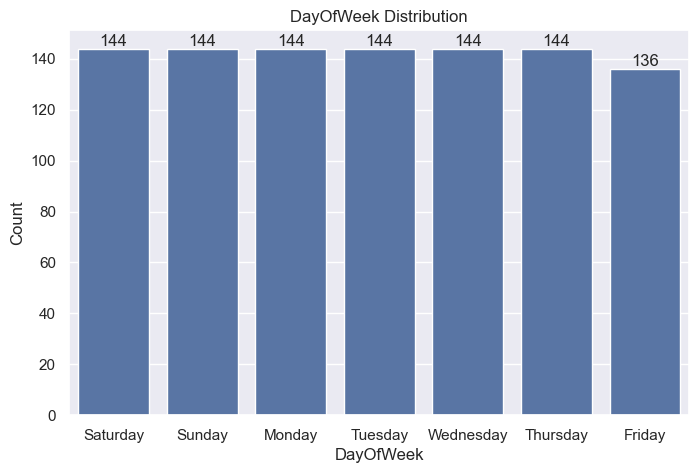

In [12]:
Day_counts = df['DayOfWeek'].value_counts().sort_values(ascending=False)
plt.figure(figsize=(8, 5))
day = sns.countplot(data=df, x='DayOfWeek', order=Day_counts.index)

for p in day.patches:
    day.annotate(
        f'{int(p.get_height())}',  
        (p.get_x() + p.get_width() / 2, p.get_height()),  
        ha='center',  
        va='bottom'  
    )

plt.title("DayOfWeek Distribution")
plt.xlabel("DayOfWeek")
plt.ylabel("Count")
plt.show()

In [13]:
df['HVACUsage'].value_counts()

HVACUsage
Off    508
On     492
Name: count, dtype: int64

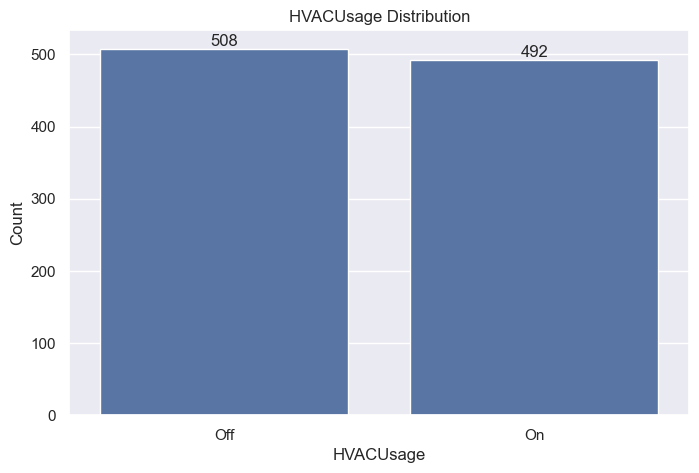

In [14]:
HVACUsage_counts = df['HVACUsage'].value_counts().sort_values(ascending=False)
plt.figure(figsize=(8, 5))
HVACUsage = sns.countplot(data=df, x='HVACUsage', order=HVACUsage_counts.index)

for p in HVACUsage.patches:
    HVACUsage.annotate(
        f'{int(p.get_height())}',  
        (p.get_x() + p.get_width() / 2, p.get_height()),  
        ha='center',  
        va='bottom'  
    )

plt.title("HVACUsage Distribution")
plt.xlabel("HVACUsage")
plt.ylabel("Count")
plt.show()

In [15]:
df['LightingUsage'].value_counts()

LightingUsage
Off    509
On     491
Name: count, dtype: int64

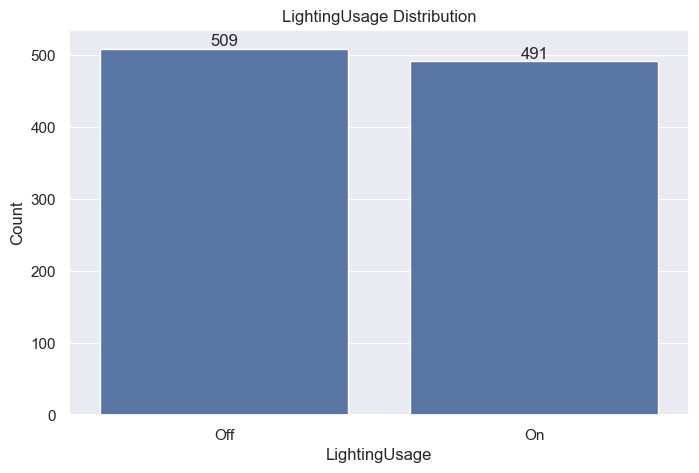

In [16]:
LightingUsage_counts = df['LightingUsage'].value_counts().sort_values(ascending=False)
plt.figure(figsize=(8, 5))
LightingUsage = sns.countplot(data=df, x='LightingUsage', order=LightingUsage_counts.index)

for p in LightingUsage.patches:
    LightingUsage.annotate(
        f'{int(p.get_height())}',  
        (p.get_x() + p.get_width() / 2, p.get_height()),  
        ha='center',  
        va='bottom'  
    )

plt.title("LightingUsage Distribution")
plt.xlabel("LightingUsage")
plt.ylabel("Count")
plt.show()

In [17]:
df['Holiday'].value_counts()

Holiday
No     533
Yes    467
Name: count, dtype: int64

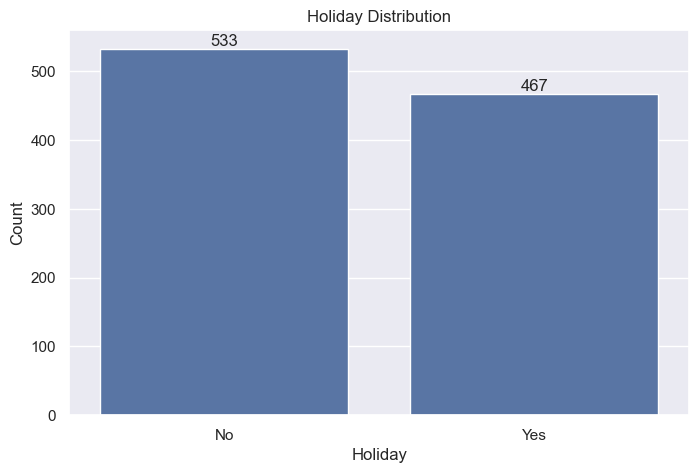

In [18]:
Holiday_counts = df['Holiday'].value_counts().sort_values(ascending=False)
plt.figure(figsize=(8, 5))
Holiday = sns.countplot(data=df, x='Holiday', order=Holiday_counts.index)

for p in Holiday.patches:
    Holiday.annotate(
        f'{int(p.get_height())}',  
        (p.get_x() + p.get_width() / 2, p.get_height()),  
        ha='center',  
        va='bottom'  
    )

plt.title("Holiday Distribution")
plt.xlabel("Holiday")
plt.ylabel("Count")
plt.show()

## Insight

Based on the exploratory data analysis (EDA), the categorical features appear to be evenly distributed. To prepare the data and preserve potential inherent order (especially for features like DayOfWeek), I'll use the OrdinalEncoder to convert the categorical variables into numerical format with a predefined, meaningful order.

## Relationship between EnergyConsumption and Categorical Features

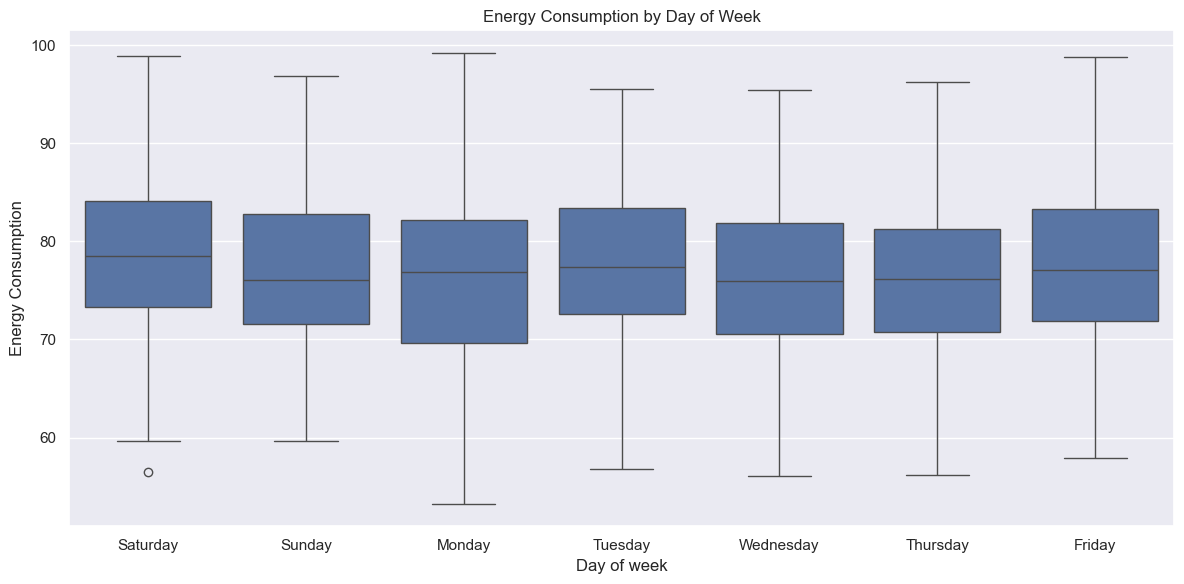

In [22]:


plt.figure(figsize=(12, 6))  
sns.boxplot(x='DayOfWeek', y='EnergyConsumption', data=df)
plt.title('Energy Consumption by Day of Week')
plt.xlabel('Day of week')
plt.ylabel('Energy Consumption')
plt.tight_layout()
plt.show()

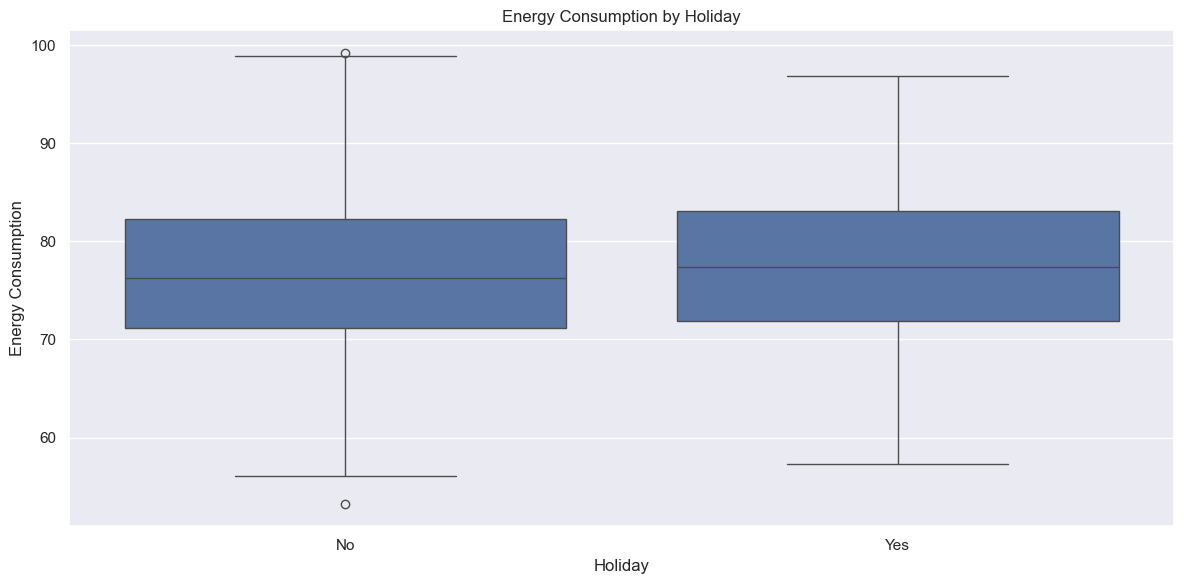

In [23]:

plt.figure(figsize=(12, 6))  
sns.boxplot(x='Holiday', y='EnergyConsumption', data=df)
plt.title('Energy Consumption by Holiday')
plt.xlabel('Holiday')
plt.ylabel('Energy Consumption')
plt.tight_layout()
plt.show()

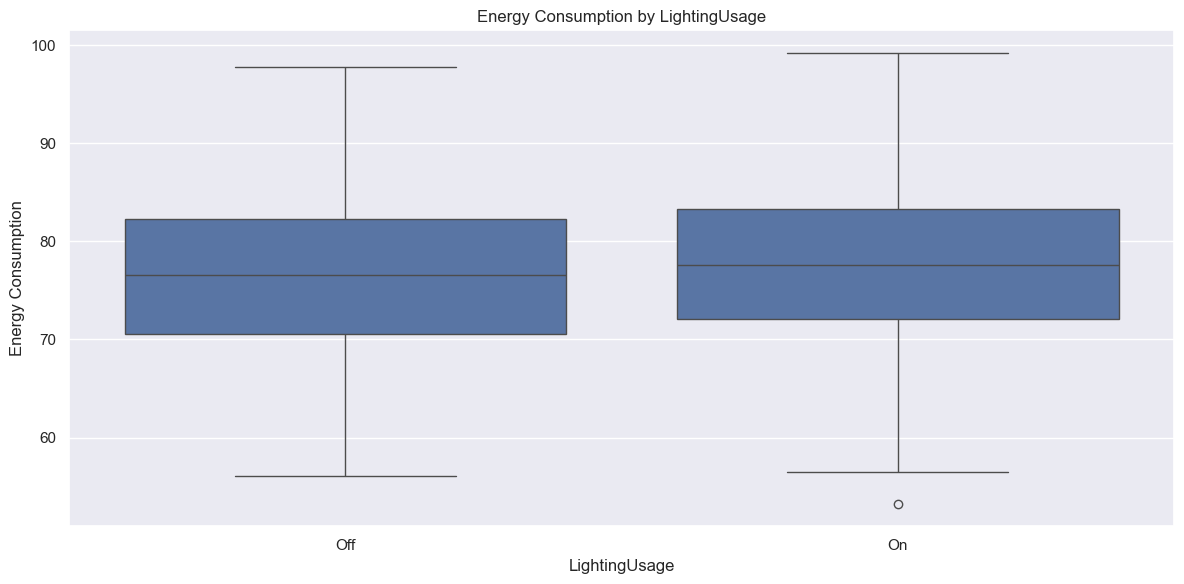

In [24]:
plt.figure(figsize=(12, 6))  
sns.boxplot(x='LightingUsage', y='EnergyConsumption', data=df)
plt.title('Energy Consumption by LightingUsage')
plt.xlabel('LightingUsage')
plt.ylabel('Energy Consumption')
plt.tight_layout()
plt.show()

In [13]:
## Using ordinal Encoder for the categorical Features

categories = [
    ['Off', 'On'],                      
    ['Off', 'On'],                       
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], 
    ['No', 'Yes']                        
]

encoder = OrdinalEncoder(categories=categories)
categorical_cols = ['HVACUsage', 'LightingUsage', 'DayOfWeek', 'Holiday']
df[categorical_cols] = encoder.fit_transform(df[categorical_cols])



In [14]:
df.head()

Temperature   Humidity  SquareFootage  Occupancy  \
Timestamp                                                               
2022-01-01 00:00:00    25.139433  43.431581    1565.693999          5   
2022-01-01 01:00:00    27.731651  54.225919    1411.064918          1   
2022-01-01 02:00:00    28.704277  58.907658    1755.715009          2   
2022-01-01 03:00:00    20.080469  50.371637    1452.316318          1   
2022-01-01 04:00:00    23.097359  51.401421    1094.130359          9   

                     HVACUsage  LightingUsage  RenewableEnergy  DayOfWeek  \
Timestamp                                                                   
2022-01-01 00:00:00        1.0            0.0         2.774699        5.0   
2022-01-01 01:00:00        1.0            1.0        21.831384        5.0   
2022-01-01 02:00:00        0.0            0.0         6.764672        5.0   
2022-01-01 03:00:00        0.0            1.0         8.623447        5.0   
2022-01-01 04:00:00        1.0            0.0         3.071969        5.0   

                     Holiday  EnergyConsumption  
Timestamp                                        
2022-01-01 00:00:00      0.0          75.364373  
2022-01-01 01:00:00      0.0          83.401855  
2022-01-01 02:00:00      0.0          78.270888  
2022-01-01 03:00:00      0.0          56.519850  
2022-01-01 04:00:00      0.0          70.811732

# Exploratory Data Analysis on Numerical Features

### Exploring deeply  the Energyconsumption variable 

<Axes: xlabel='Timestamp'>

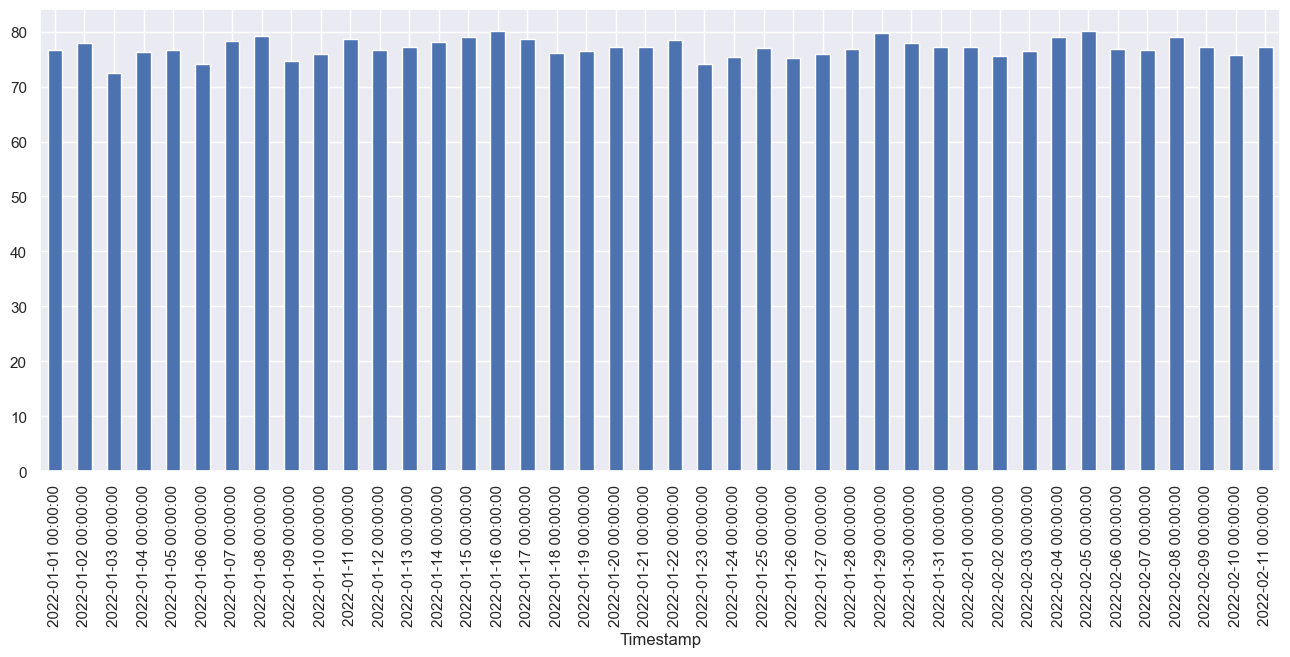

In [27]:
df['EnergyConsumption'].resample('D').mean().plot.bar(figsize=(16,6))

In [28]:
df['EnergyConsumption'].plot(figsize=(16,6))

<Axes: xlabel='Timestamp'>

In [29]:
## checking the ETS decomposition

result = seasonal_decompose(df['EnergyConsumption'], model='additive', period=24) 
result.plot();
plt.tight_layout()
plt.show()


In [30]:


df['Hour'] = df.index.hour
df.groupby('Hour')['EnergyConsumption'].mean().plot(kind='line', title='Average Energy Consumption by Hour')



<Axes: title={'center': 'Average Energy Consumption by Hour'}, xlabel='Hour'>

# SMA - Simple Moving Average

In [31]:
df['7-day-SMA'] = df['EnergyConsumption'].rolling(window=7).mean()
df['14-day-SMA'] = df['EnergyConsumption'].rolling(window=14).mean()

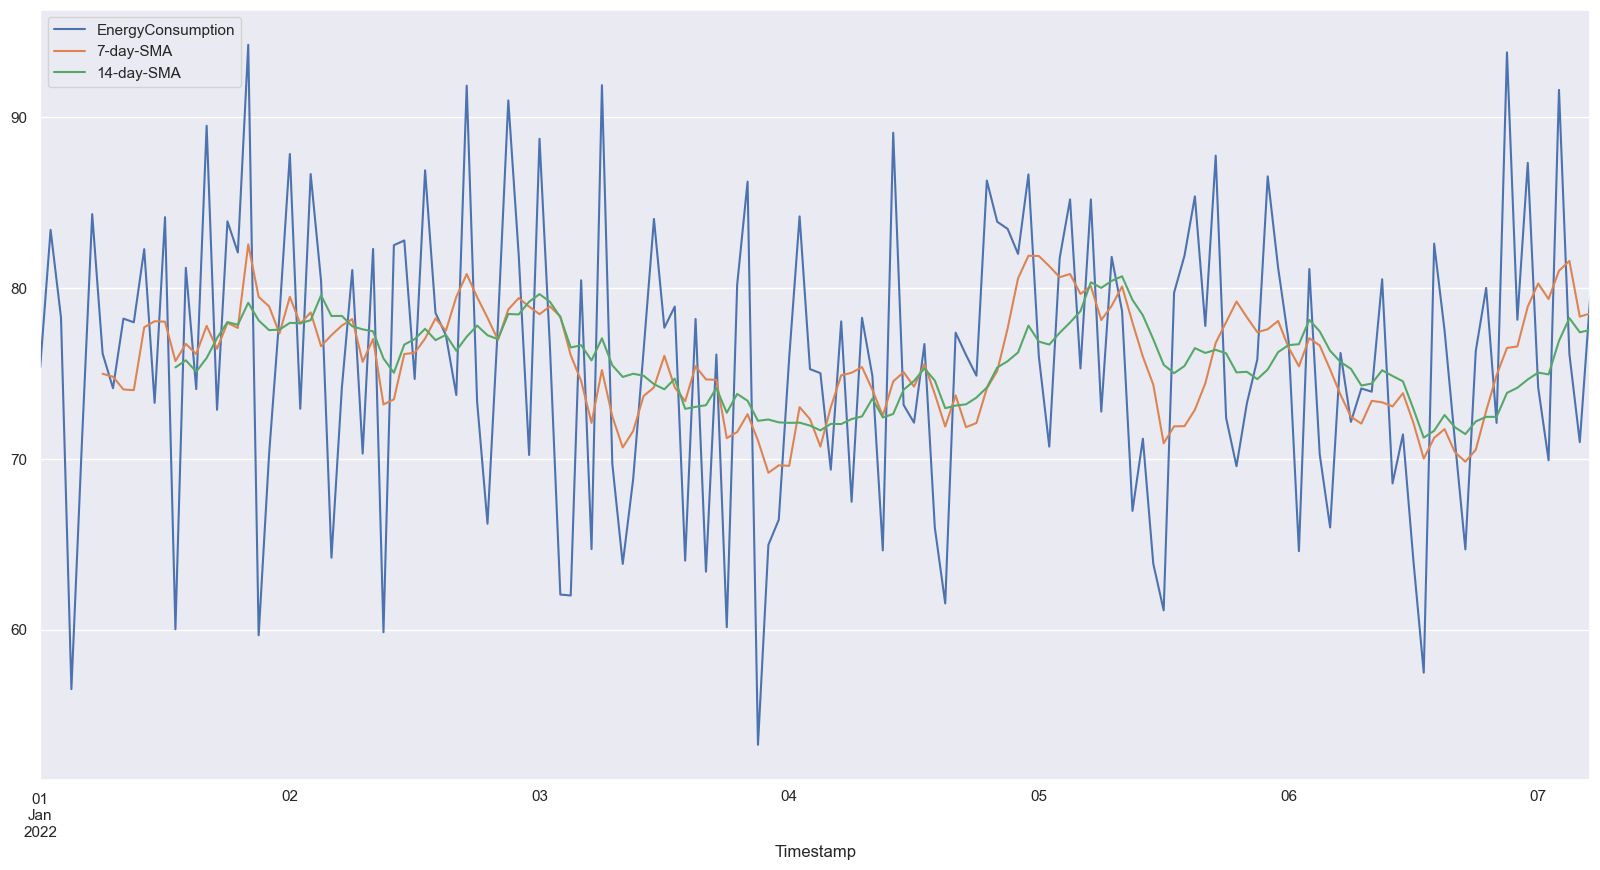

In [32]:
df[['EnergyConsumption','7-day-SMA', '14-day-SMA']].iloc[:150].plot(figsize = (20,10));

## EWMA - Exponentially Weighted Moving Average

In [33]:
df['EWMA-14'] =  df['EnergyConsumption'].ewm(span = 14).mean()

<Axes: xlabel='Timestamp'>

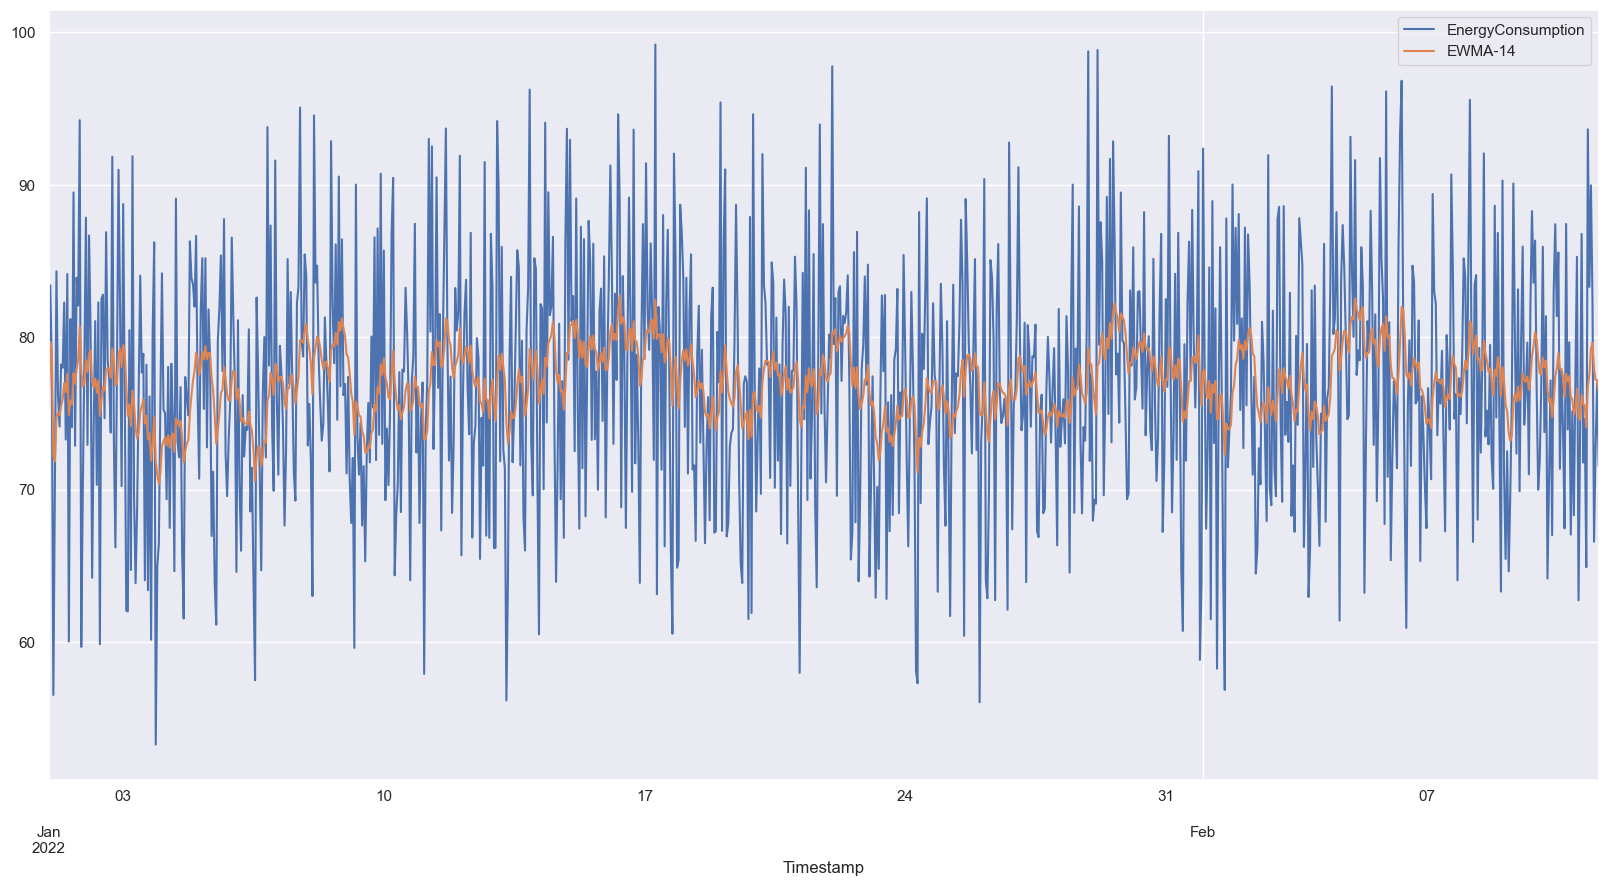

In [34]:
 df[['EnergyConsumption','EWMA-14']].plot(figsize=(20,10))

# SES - Simple Exponential Smoothing

In [35]:
span = 14
alpha = 2/(span+1)

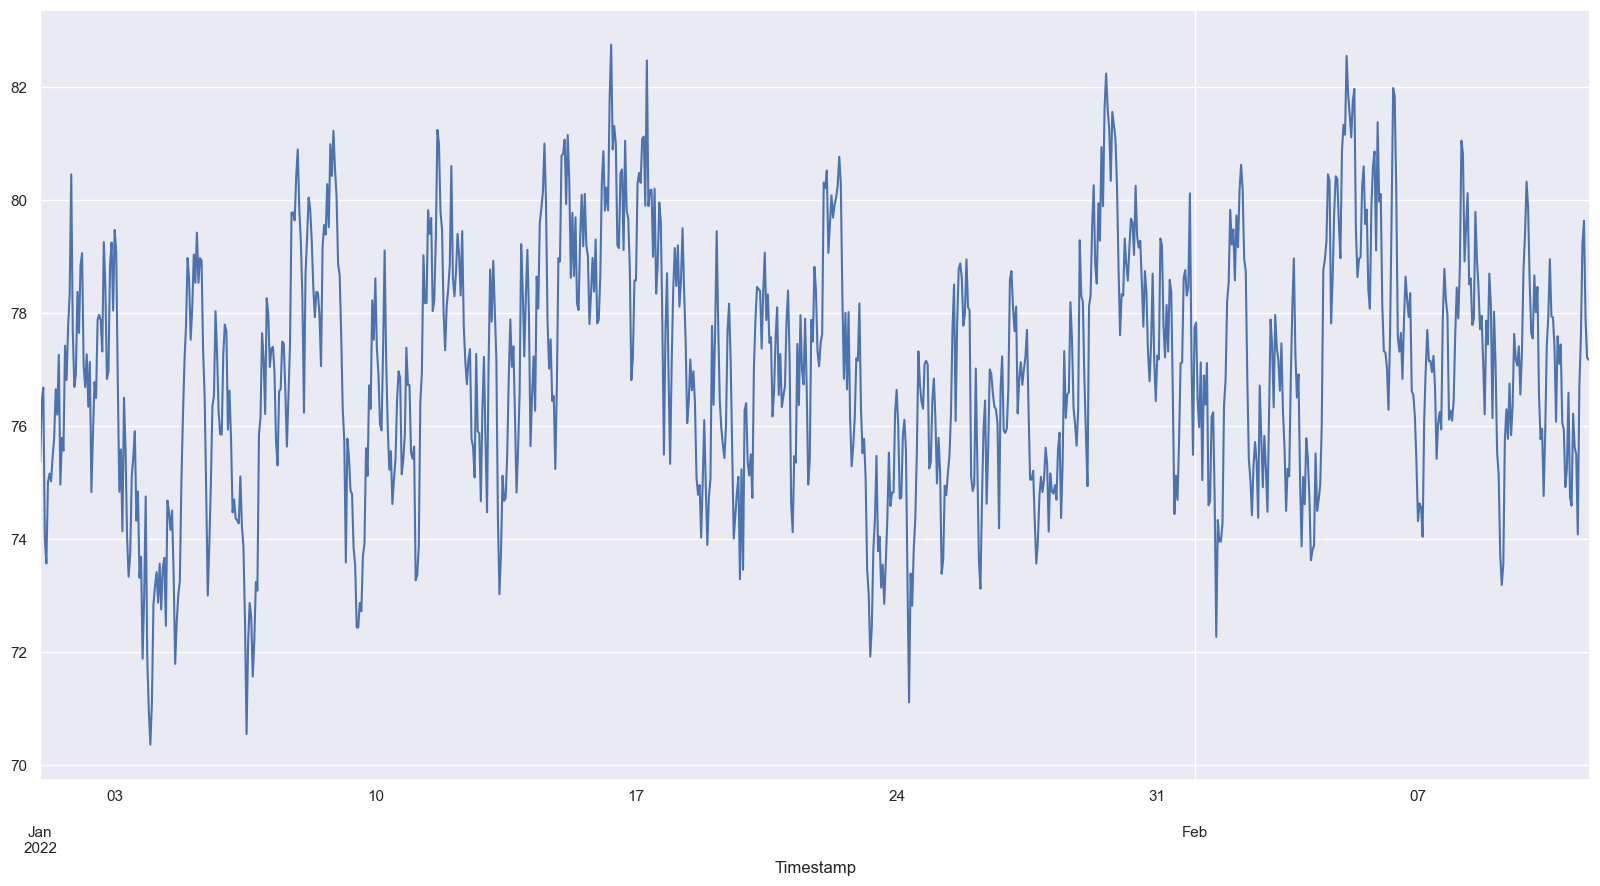

In [36]:
df['SES14'] = SimpleExpSmoothing(df['EnergyConsumption']).fit(smoothing_level = alpha,optimized=False).fittedvalues.shift(-1).plot(figsize = (20,10))

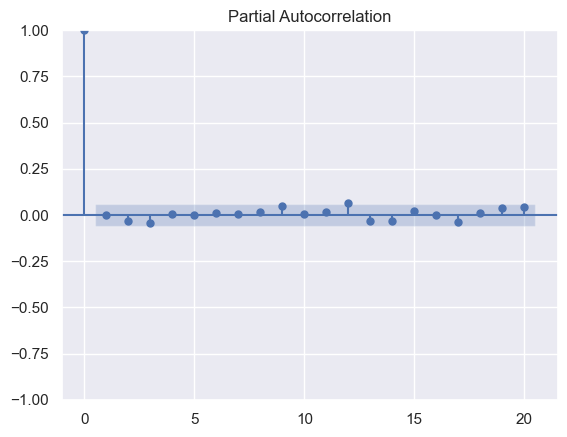

In [40]:
plot_acf(df['EnergyConsumption'], lags=20)
plot_pacf(df['EnergyConsumption'], lags=20)
plt.show()

##  visualizing  relationship between numerical features  and EnergyConsumption

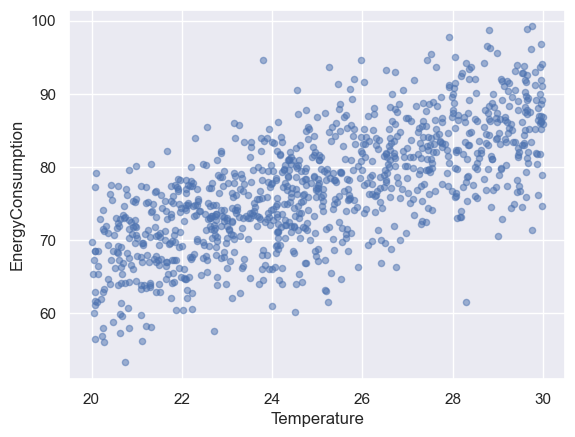

In [41]:
df.plot(x='Temperature', y='EnergyConsumption', kind='scatter', alpha=0.5)
plt.show()


In [42]:
df.plot(x='Humidity', y='EnergyConsumption', kind='scatter', alpha=0.5)
plt.show()

In [43]:
df.plot(x='SquareFootage', y='EnergyConsumption', kind='scatter', alpha=0.5)
plt.show()

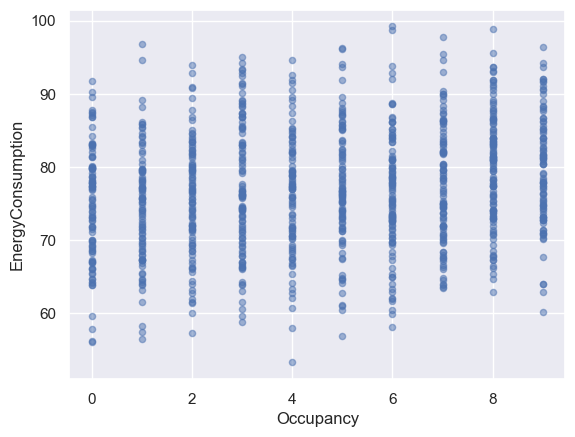

In [44]:
df.plot(x='Occupancy', y='EnergyConsumption', kind='scatter', alpha=0.5)
plt.show()

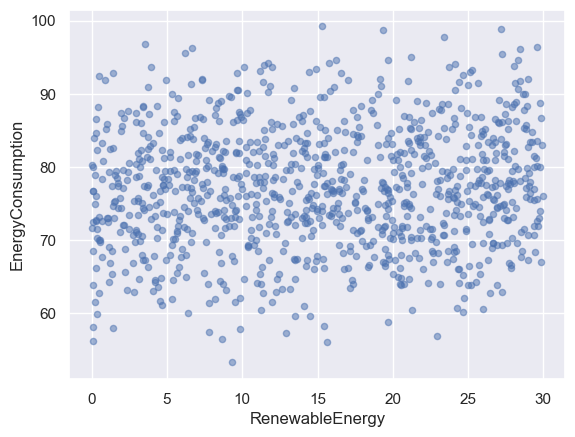

In [45]:
df.plot(x='RenewableEnergy', y='EnergyConsumption', kind='scatter', alpha=0.5)
plt.show()

## Insight 

From the exploratory data analysis (EDA), it is evident that Temperature shows a noticeable relationship with EnergyConsumption. However, it is important to remember that correlation does not imply causation. To further investigate whether this relationship is causal, I will perform statistical tests to assess the potential causality between these features.

## performing Granger Causality Test to check whether numerical features  can be used to predict EnergyConsumption.

# Granger causality test 

In [46]:
grangercausalitytests(df[['EnergyConsumption', 'Temperature']], maxlag=3);


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0015  , p=0.9693  , df_denom=996, df_num=1
ssr based chi2 test:   chi2=0.0015  , p=0.9692  , df=1
likelihood ratio test: chi2=0.0015  , p=0.9692  , df=1
parameter F test:         F=0.0015  , p=0.9693  , df_denom=996, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0052  , p=0.9948  , df_denom=993, df_num=2
ssr based chi2 test:   chi2=0.0104  , p=0.9948  , df=2
likelihood ratio test: chi2=0.0104  , p=0.9948  , df=2
parameter F test:         F=0.0052  , p=0.9948  , df_denom=993, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.0529  , p=0.9840  , df_denom=990, df_num=3
ssr based chi2 test:   chi2=0.1598  , p=0.9838  , df=3
likelihood ratio test: chi2=0.1597  , p=0.9838  , df=3
parameter F test:         F=0.0529  , p=0.9840  , df_denom=990, df_num=3


In [47]:
grangercausalitytests(df[['Occupancy','EnergyConsumption']],maxlag=3);


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0232  , p=0.8789  , df_denom=996, df_num=1
ssr based chi2 test:   chi2=0.0233  , p=0.8787  , df=1
likelihood ratio test: chi2=0.0233  , p=0.8787  , df=1
parameter F test:         F=0.0232  , p=0.8789  , df_denom=996, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.3557  , p=0.7007  , df_denom=993, df_num=2
ssr based chi2 test:   chi2=0.7151  , p=0.6994  , df=2
likelihood ratio test: chi2=0.7148  , p=0.6995  , df=2
parameter F test:         F=0.3557  , p=0.7007  , df_denom=993, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.6727  , p=0.5688  , df_denom=990, df_num=3
ssr based chi2 test:   chi2=2.0325  , p=0.5657  , df=3
likelihood ratio test: chi2=2.0304  , p=0.5661  , df=3
parameter F test:         F=0.6727  , p=0.5688  , df_denom=990, df_num=3


In [48]:
grangercausalitytests(df[['Humidity','EnergyConsumption']],maxlag=3);


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0430  , p=0.8358  , df_denom=996, df_num=1
ssr based chi2 test:   chi2=0.0431  , p=0.8355  , df=1
likelihood ratio test: chi2=0.0431  , p=0.8355  , df=1
parameter F test:         F=0.0430  , p=0.8358  , df_denom=996, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0610  , p=0.9409  , df_denom=993, df_num=2
ssr based chi2 test:   chi2=0.1226  , p=0.9406  , df=2
likelihood ratio test: chi2=0.1225  , p=0.9406  , df=2
parameter F test:         F=0.0610  , p=0.9409  , df_denom=993, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.6812  , p=0.5636  , df_denom=990, df_num=3
ssr based chi2 test:   chi2=2.0582  , p=0.5604  , df=3
likelihood ratio test: chi2=2.0560  , p=0.5609  , df=3
parameter F test:         F=0.6812  , p=0.5636  , df_denom=990, df_num=3


In [49]:
grangercausalitytests(df[['SquareFootage','EnergyConsumption']],maxlag=3);


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0364  , p=0.8488  , df_denom=996, df_num=1
ssr based chi2 test:   chi2=0.0365  , p=0.8485  , df=1
likelihood ratio test: chi2=0.0365  , p=0.8485  , df=1
parameter F test:         F=0.0364  , p=0.8488  , df_denom=996, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1104  , p=0.8955  , df_denom=993, df_num=2
ssr based chi2 test:   chi2=0.2218  , p=0.8950  , df=2
likelihood ratio test: chi2=0.2218  , p=0.8950  , df=2
parameter F test:         F=0.1104  , p=0.8955  , df_denom=993, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.1932  , p=0.9010  , df_denom=990, df_num=3
ssr based chi2 test:   chi2=0.5838  , p=0.9001  , df=3
likelihood ratio test: chi2=0.5837  , p=0.9002  , df=3
parameter F test:         F=0.1932  , p=0.9010  , df_denom=990, df_num=3


In [50]:
grangercausalitytests(df[['RenewableEnergy','EnergyConsumption']],maxlag=3);


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0461  , p=0.3067  , df_denom=996, df_num=1
ssr based chi2 test:   chi2=1.0492  , p=0.3057  , df=1
likelihood ratio test: chi2=1.0487  , p=0.3058  , df=1
parameter F test:         F=1.0461  , p=0.3067  , df_denom=996, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.5686  , p=0.2088  , df_denom=993, df_num=2
ssr based chi2 test:   chi2=3.1531  , p=0.2067  , df=2
likelihood ratio test: chi2=3.1481  , p=0.2072  , df=2
parameter F test:         F=1.5686  , p=0.2088  , df_denom=993, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.1205  , p=0.3397  , df_denom=990, df_num=3
ssr based chi2 test:   chi2=3.3852  , p=0.3360  , df=3
likelihood ratio test: chi2=3.3795  , p=0.3367  , df=3
parameter F test:         F=1.1205  , p=0.3397  , df_denom=990, df_num=3


## Insight

Although the exploratory data analysis showed a visual correlation between temperature and energy consumption, the Granger causality test reveals that temperature does not statistically Granger-cause energy consumption. This suggests that the observed relationship may not imply a predictive or causal effect. Additionally, the rest numberical features  Granger cause EnergyConsumption i.e. past values of those features  do not help predict future EnergyConsumption in a statistically significant way.

PLEASE NOTE : This p-value is very high (much greater than 0.05), which means i fail to reject the null hypothesis.



<Axes: xlabel='Timestamp'>

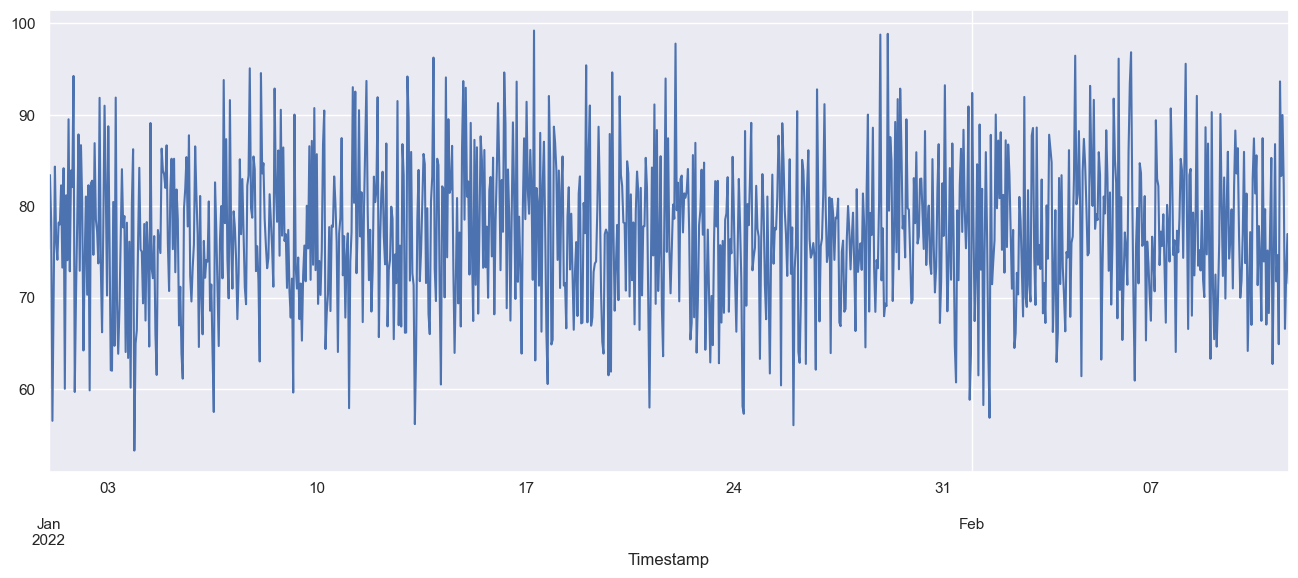

In [51]:
df['EnergyConsumption'].plot(figsize=(16,6))

## Based on the exploratory data analysis (EDA) conducted so far, the time series appears to be stationary. However, to confirm this observation with statistical evidence, I will perform a formal stationarity test on the data which is the Augmented Dickey-Fuller (ADF) test — to validate whether the statistical properties (mean, variance, autocorrelation) remain constant over time.

# Augmented Dickey-Fuller Test

In [52]:
## creating the Augmented Dickey-Fuller Test function

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') 
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())        
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [53]:
adf_test(df['RenewableEnergy'])

Augmented Dickey-Fuller Test: 
ADF test statistic      -31.932256
p-value                   0.000000
# lags used               0.000000
# observations          999.000000
critical value (1%)      -3.436913
critical value (5%)      -2.864437
critical value (10%)     -2.568313
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [54]:
adf_test(df['Humidity'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -1.647441e+01
p-value                 2.267368e-29
# lags used             2.000000e+00
# observations          9.970000e+02
critical value (1%)    -3.436926e+00
critical value (5%)    -2.864443e+00
critical value (10%)   -2.568316e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [55]:
adf_test(df['Temperature'])

Augmented Dickey-Fuller Test: 
ADF test statistic      -32.226920
p-value                   0.000000
# lags used               0.000000
# observations          999.000000
critical value (1%)      -3.436913
critical value (5%)      -2.864437
critical value (10%)     -2.568313
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [56]:
adf_test(df['SquareFootage'])

Augmented Dickey-Fuller Test: 
ADF test statistic      -32.364591
p-value                   0.000000
# lags used               0.000000
# observations          999.000000
critical value (1%)      -3.436913
critical value (5%)      -2.864437
critical value (10%)     -2.568313
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [57]:
adf_test(df['EnergyConsumption'])

Augmented Dickey-Fuller Test: 
ADF test statistic      -31.576934
p-value                   0.000000
# lags used               0.000000
# observations          999.000000
critical value (1%)      -3.436913
critical value (5%)      -2.864437
critical value (10%)     -2.568313
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


## Insight 
Based on the results of the statistical stationarity test, the numerical features in the dataset are confirmed to be stationary. This means their statistical properties—such as mean and variance—remain constant over time. As a result, there is no need to apply differencing or other transformations to make the series stationary before modeling.

# Checking for correlation between numerical features and energyconsumption using cross correlation 

## cross- correlation

In [58]:
df['Temperature'].corr(df['EnergyConsumption'])


0.6964103773314035

In [59]:
df['SquareFootage'].corr(df['EnergyConsumption'])

-0.001129061410164112

In [60]:
df['Humidity'].corr(df['EnergyConsumption'])

-0.09358284322013086

In [61]:
df['Occupancy'].corr(df['EnergyConsumption'])

0.18658043461482587

In [62]:
df['RenewableEnergy'].corr(df['EnergyConsumption'])

0.08115968233976739

In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1000 entries, 2022-01-01 00:00:00 to 2022-02-11 15:00:00
Freq: h
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Temperature        1000 non-null   float64
 1   Humidity           1000 non-null   float64
 2   SquareFootage      1000 non-null   float64
 3   Occupancy          1000 non-null   int64  
 4   HVACUsage          1000 non-null   float64
 5   LightingUsage      1000 non-null   float64
 6   RenewableEnergy    1000 non-null   float64
 7   DayOfWeek          1000 non-null   float64
 8   Holiday            1000 non-null   float64
 9   EnergyConsumption  1000 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 85.9 KB


In [81]:
df.describe().transpose()

count         mean         std          min          25%  \
Temperature        1000.0    24.982026    2.836850    20.007565    22.645070   
Humidity           1000.0    45.395412    8.518905    30.015975    38.297722   
SquareFootage      1000.0  1500.052488  288.418873  1000.512661  1247.108548   
Occupancy          1000.0     4.581000    2.865598     0.000000     2.000000   
HVACUsage          1000.0     0.492000    0.500186     0.000000     0.000000   
LightingUsage      1000.0     0.491000    0.500169     0.000000     0.000000   
RenewableEnergy    1000.0    15.132813    8.745917     0.006642     7.628385   
DayOfWeek          1000.0     2.992000    2.006979     0.000000     1.000000   
Holiday            1000.0     0.467000    0.499159     0.000000     0.000000   
EnergyConsumption  1000.0    77.055873    8.144112    53.263278    71.544690   

                           50%          75%          max  
Temperature          24.751637    27.418174    29.998671  
Humidity             45.972116    52.420066    59.969085  
SquareFootage      1507.967426  1740.340165  1999.982252  
Occupancy             5.000000     7.000000     9.000000  
HVACUsage             0.000000     1.000000     1.000000  
LightingUsage         0.000000     1.000000     1.000000  
RenewableEnergy      15.072296    22.884064    29.965327  
DayOfWeek             3.000000     5.000000     6.000000  
Holiday               0.000000     1.000000     1.000000  
EnergyConsumption    76.943696    82.921742    99.201120

In [82]:
df.isna().sum()

Temperature          0
Humidity             0
SquareFootage        0
Occupancy            0
HVACUsage            0
LightingUsage        0
RenewableEnergy      0
DayOfWeek            0
Holiday              0
EnergyConsumption    0
dtype: int64

# Final Insight and Model Selection

Recall that i performed Granger causality tests to determine whether any of the available features could help forecast future values of EnergyConsumption. The results showed that all features had p-values greater than 0.05, which indicates the following:

- None of the features significantly Granger-cause EnergyConsumption.

- They are unlikely to improve the forecasting performance in a linear modeling context.

Due to this, I will not proceed with models like VAR (Vector Autoregression) or VARMA (Vector Autoregressive Moving Average), even though these models are designed for multivariate time series. This decision is based on the fact that the Granger causality test failed to reject the null hypothesis for all features — meaning their past values do not help predict the target variable.

As a result, I will simplify the modeling pipeline by removing all other features and focus on forecasting using only the EnergyConsumption series. I will train a univariate ARIMA model, which is well-suited for capturing the temporal dynamics, trend, and seasonality of a single time series.

However, I also recognize that Granger causality tests only detect linear relationships. It's possible that the features still hold nonlinear or lagged dependencies that traditional statistical models can't capture. Therefore:

- I will also build and evaluate a deep learning model like  LSTM using all features.
-  These models are capable of learning complex temporal patterns and interactions, which may improve predictive performance even when statistical tests suggest otherwise.

In [15]:
df1 = df[['EnergyConsumption']]


# Model Development Phase

In [16]:
df1

EnergyConsumption
Timestamp                             
2022-01-01 00:00:00          75.364373
2022-01-01 01:00:00          83.401855
2022-01-01 02:00:00          78.270888
2022-01-01 03:00:00          56.519850
2022-01-01 04:00:00          70.811732
...                                ...
2022-02-11 11:00:00          82.306692
2022-02-11 12:00:00          66.577320
2022-02-11 13:00:00          72.753471
2022-02-11 14:00:00          76.950389
2022-02-11 15:00:00          71.545311

[1000 rows x 1 columns]

In [17]:
nobs = 48

In [18]:
train_data = df1[:-nobs]

In [19]:
train_data.head()

EnergyConsumption
Timestamp                             
2022-01-01 00:00:00          75.364373
2022-01-01 01:00:00          83.401855
2022-01-01 02:00:00          78.270888
2022-01-01 03:00:00          56.519850
2022-01-01 04:00:00          70.811732

In [20]:
test_data = df1[-nobs:]

In [21]:
test_data.head()


EnergyConsumption
Timestamp                             
2022-02-09 16:00:00          76.356418
2022-02-09 17:00:00          79.643493
2022-02-09 18:00:00          70.996554
2022-02-09 19:00:00          82.106337
2022-02-09 20:00:00          88.269880


## Building a simple holtwinters model 


In [22]:

model = ExponentialSmoothing(
    train_data['EnergyConsumption'],
    trend='add',         
    seasonal='add',     
    seasonal_periods=12   
)
fitted_model = model.fit()


In [23]:
## Please ensure that your forecast horizon matches the number of observations in your test dataset

test_predictions = fitted_model.forecast(48)

In [24]:
test_predictions.head()

2022-02-09 16:00:00    77.267916
2022-02-09 17:00:00    77.889897
2022-02-09 18:00:00    77.283937
2022-02-09 19:00:00    78.261325
2022-02-09 20:00:00    77.837150
Freq: h, dtype: float64

In [25]:
train_data['EnergyConsumption'].plot(legend = True,label='TRAIN',figsize=(20,10))
test_data['EnergyConsumption'].plot(legend = True,label='TEST',figsize=(20,10))

<Axes: xlabel='Timestamp'>

<Axes: xlabel='Timestamp'>

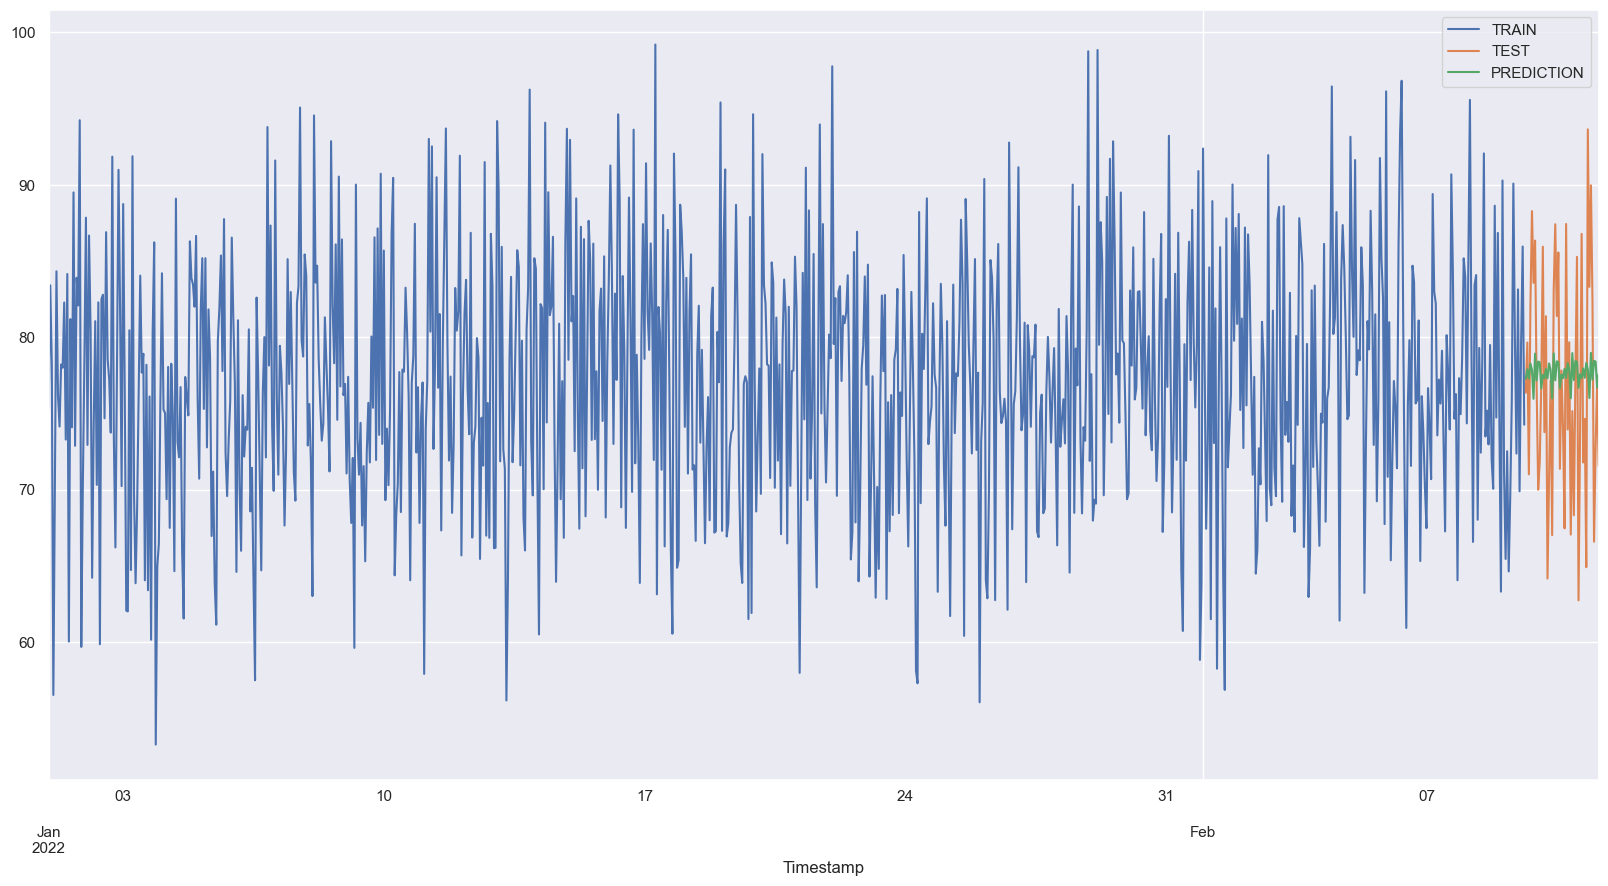

In [26]:
train_data['EnergyConsumption'].plot(legend = True,label='TRAIN',figsize=(20,10))
test_data['EnergyConsumption'].plot(legend = True,label='TEST',figsize=(20,10))
test_predictions.plot(legend= True, label = 'PREDICTION')

In [27]:
## Visualizing the test data and forecast and slicing out the train data

train_data['EnergyConsumption'].plot(legend = True,label='TRAIN',figsize=(20,10))
test_data['EnergyConsumption'].plot(legend = True,label='TEST',figsize=(20,10))
test_predictions.plot(legend= True, label = 'PREDICTION',xlim=['2022-02-09 16:00:00','2022-02-11 15:00:00']	)

<Axes: xlabel='Timestamp'>

In [28]:
test_data.describe()

EnergyConsumption
count          48.000000
mean           77.013042
std             7.605521
min            62.729873
25%            71.498929
50%            76.850458
75%            83.128351
max            93.639644

## Evaluating holtwinter model

In [29]:

mean_absolute_error(test_data,test_predictions)

6.289712026582989

In [30]:
mean_squared_error(test_data, test_predictions)

55.41069779328112

In [31]:
np.sqrt(mean_squared_error(test_data, test_predictions))

7.4438362282684

## Now, train the Holt-Winters model on the entire dataset and generate a forecast for the next 48 hours into the future.

In [32]:
hott_model = ExponentialSmoothing(df1['EnergyConsumption'],trend='add',seasonal='add',seasonal_periods=12)
fitted_final_model = hott_model.fit()

In [33]:
forecast_predictions = fitted_final_model.forecast(48)

In [34]:
forecast_predictions.head()

2022-02-11 16:00:00    76.974357
2022-02-11 17:00:00    77.576527
2022-02-11 18:00:00    76.914117
2022-02-11 19:00:00    77.771295
2022-02-11 20:00:00    77.898986
Freq: h, dtype: float64

<Axes: xlabel='Timestamp'>

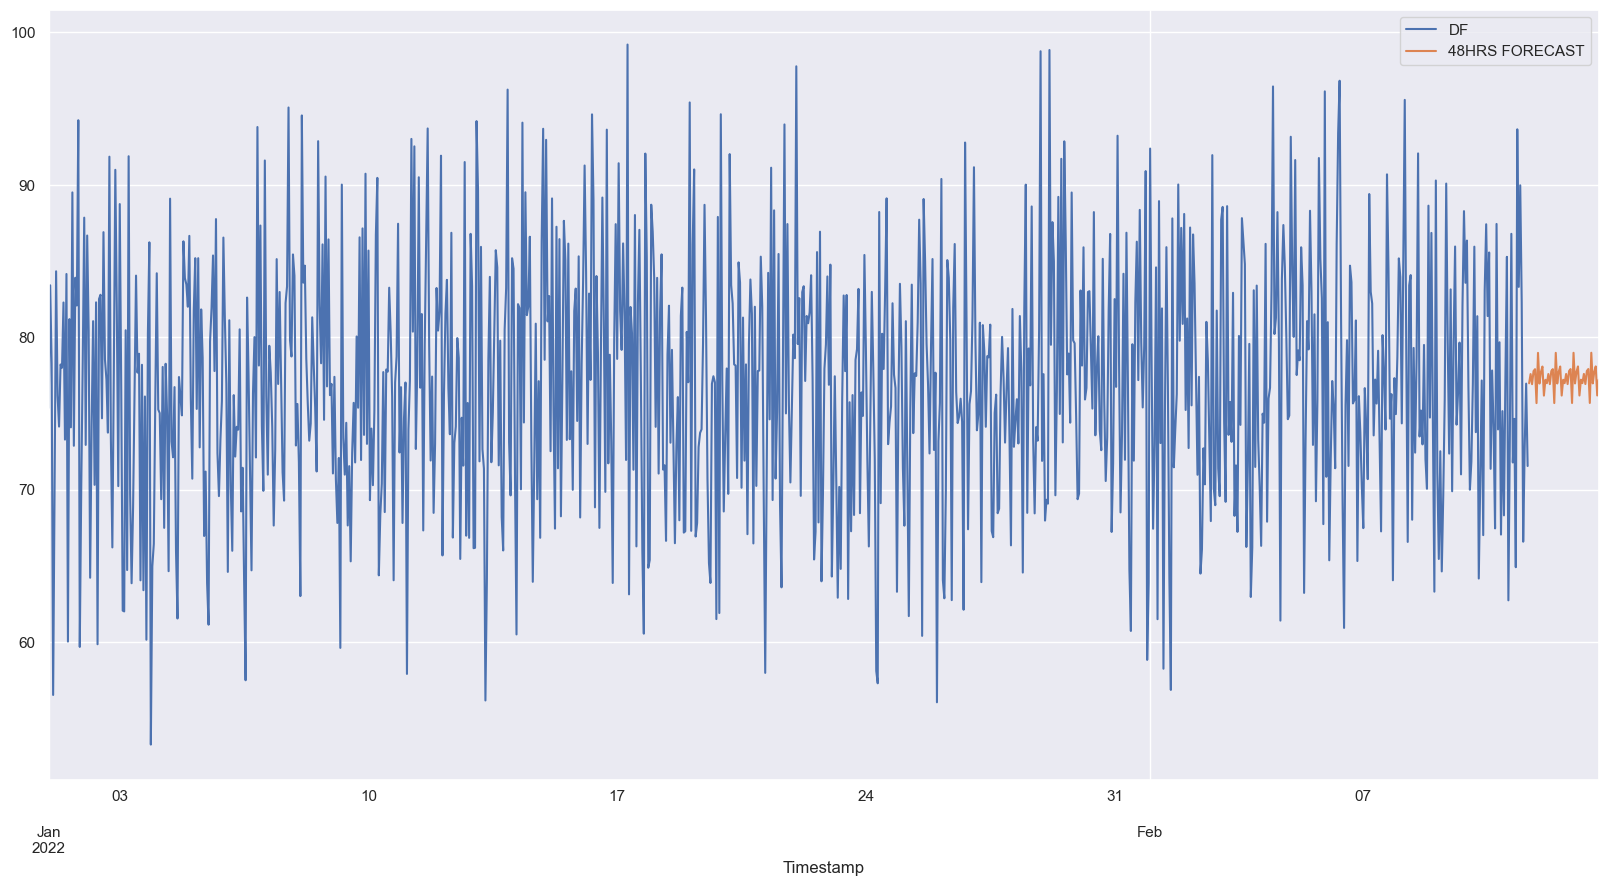

In [35]:
df['EnergyConsumption'].plot(legend = True, label = "DF",figsize= (20,10))
forecast_predictions.plot(legend = True, label = "48HRS FORECAST")

# Insight on holtwinter model:
The test data has a mean of 77,std of 7.6 and the model achieves a Mean Absolute Error (MAE) of 6.2, Root Mean Squared Error(RMSE) of 7.4 which  indicates that its performance is reasonably good.

## Building an AR Model

In [36]:
train_data.head()

EnergyConsumption
Timestamp                             
2022-01-01 00:00:00          75.364373
2022-01-01 01:00:00          83.401855
2022-01-01 02:00:00          78.270888
2022-01-01 03:00:00          56.519850
2022-01-01 04:00:00          70.811732

In [37]:
ARmodel = AutoReg(train_data['EnergyConsumption'],lags= 3)

In [38]:
start = len(train_data)

In [39]:
end = len(train_data) + len(test_data) - 1

In [40]:
ARfit = ARmodel.fit()

In [41]:
ARfit.params

const                   82.844900
EnergyConsumption.L1    -0.001852
EnergyConsumption.L2    -0.032929
EnergyConsumption.L3    -0.040404
dtype: float64

In [42]:
AR_test_predictions = ARfit.predict(start,end)

## Evaluating AR Model

In [43]:
mean_absolute_error(test_data,AR_test_predictions)

6.299766755097309

In [44]:
mean_squared_error(test_data, AR_test_predictions)

56.68863486448853

In [45]:
np.sqrt(mean_squared_error(test_data, AR_test_predictions))

7.529185537924306

## Now, train the AR model on the entire dataset and generate a forecast for the next 48 hours into the future

In [46]:
AR_model = AutoReg(df1['EnergyConsumption'],lags= 3)

In [47]:
ARfitt = AR_model.fit()

In [48]:
Forecasted_values = ARfitt.predict(start=len(df),end=len(df)+48)

In [49]:
Forecasted_values.head()


2022-02-11 16:00:00    77.249108
2022-02-11 17:00:00    77.226155
2022-02-11 18:00:00    77.283207
2022-02-11 19:00:00    77.036620
2022-02-11 20:00:00    77.036232
Freq: h, dtype: float64

# Building an ARIMA Model

In [50]:
stepwise_fit = auto_arima(df1['EnergyConsumption'],start_p=0,start_q=0,max_p=6,max_q=3,seasonal=False,trace = True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=11540.036, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=7727.801, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=10432.970, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=7037.467, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=7035.467, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=7037.467, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=7039.463, Time=0.09 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.536 seconds


In [51]:
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1000
Model:                        SARIMAX   Log Likelihood               -3515.733
Date:                Wed, 14 May 2025   AIC                           7035.467
Time:                        18:07:11   BIC                           7045.282
Sample:                    01-01-2022   HQIC                          7039.197
                         - 02-11-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     77.0559      0.257    299.284      0.000      76.551      77.560
sigma2        66.2602      3.219     20.583      0.000      59.951      72.570
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 3.99
Prob(Q):                              0.99   Prob(JB):                         0.14
Heteroskedasticity (H):               0.95   Skew:                             0.03
Prob(H) (two-sided):                  0.61   Kurtosis:                         2.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [52]:
model = ARIMA(train_data['EnergyConsumption'],order=(0,0,0))

In [53]:
results = model.fit()

In [54]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      EnergyConsumption   No. Observations:                  952
Model:                          ARIMA   Log Likelihood               -3350.450
Date:                Wed, 14 May 2025   AIC                           6704.900
Time:                        18:07:12   BIC                           6714.617
Sample:                    01-01-2022   HQIC                          6708.602
                         - 02-09-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         77.0580      0.265    290.972      0.000      76.539      77.577
sigma2        66.7454      3.307     20.185      0.000      60.264      73.226
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 3.37
Prob(Q):                              0.99   Prob(JB):                         0.19
Heteroskedasticity (H):               0.93   Skew:                             0.02
Prob(H) (two-sided):                  0.49   Kurtosis:                         2.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [55]:
predictions = results.predict(start,end)

In [56]:
test_data.mean()

EnergyConsumption    77.013042
dtype: float64

In [57]:
predictions.mean()

77.05802722111152

## Evaluating ARIMA model

In [58]:
mean_absolute_error(test_data,predictions)

6.300802212286132

In [59]:
mean_squared_error(test_data,predictions)

56.64088838437692

In [60]:
np.sqrt(mean_squared_error(test_data, predictions))

7.526014110030417

## Now, train the ARIMA model on the entire dataset and generate a forecast for the next 48 hours into the future

In [61]:
ARIMA_model = ARIMA(df1['EnergyConsumption'],order= (0,0,0))

In [62]:
ARIMA_results = ARIMA_model.fit()

In [63]:
Forecasts = ARIMA_results.predict(start=len(df),end=len(df)+48)

## Statistical Model Summary table

In [64]:

Summary_metrics = {
    'Holt-Winters (ExponentialSmoothing)': {
        'MAE': mean_absolute_error(test_data, test_predictions),
        'MSE': mean_squared_error(test_data, test_predictions),
        'RMSE': np.sqrt(mean_squared_error(test_data, test_predictions))
    },
    'AR (AutoRegressive)': {
        'MAE': mean_absolute_error(test_data, AR_test_predictions),
        'MSE': mean_squared_error(test_data, AR_test_predictions),
        'RMSE': np.sqrt(mean_squared_error(test_data, AR_test_predictions))
    },
    'ARIMA': {
        'MAE': mean_absolute_error(test_data, predictions),
        'MSE': mean_squared_error(test_data, predictions),
        'RMSE': np.sqrt(mean_squared_error(test_data, predictions))
    }
}



In [65]:
metrics_df = pd.DataFrame(Summary_metrics).T

In [66]:
metrics_df

MAE        MSE      RMSE
Holt-Winters (ExponentialSmoothing)  6.289712  55.410698  7.443836
AR (AutoRegressive)                  6.299767  56.688635  7.529186
ARIMA                                6.300802  56.640888  7.526014

In [67]:
test_data.describe()

EnergyConsumption
count          48.000000
mean           77.013042
std             7.605521
min            62.729873
25%            71.498929
50%            76.850458
75%            83.128351
max            93.639644

## Overall Insights:
All three forecasting models — Holt-Winters, AR, and ARIMA — demonstrate comparable performance on the test data, with MAE around 6.3 and RMSE around 7.5. Considering the mean energy consumption of 77.01 and a standard deviation of 7.6, this level of error is relatively small, indicating that the models are capturing the underlying pattern in the data reasonably well.

Holt-Winters slightly outperforms the others, with the lowest MAE (6.29) and RMSE (7.44), suggesting it is better suited for short-term forecasting in this stationary series.

The AR and ARIMA models also provide stable results with negligible differences in error metrics, making them reliable alternatives.


## What next?  Exploring Advanced Models

Having evaluated traditional time series models — Holt-Winters, AR, and ARIMA — with promising results, the next phase involves exploring advanced forecasting techniques. I plan to implement deep learning-based models, specifically LSTM (Long Short-Term Memory)

In addition, I will incorporate Facebook Prophet, a powerful additive model designed for time series forecasting 

The goal is to compare the forecasting accuracy of all models using consistent error metrics (MAE, MSE, RMSE), and ultimately select the best-performing model based on predictive accuracy and robustness

# Model Development Phase Cont'd 

#### Since some of the exogenous variables, such as temperature and occupancy, showed a strong correlation with the target variable (energy consumption), I will now apply the SARIMAX model using these variables and compare its performance with models that exclude exogenous inputs.

In [68]:
df.head(2)

Temperature   Humidity  SquareFootage  Occupancy  \
Timestamp                                                               
2022-01-01 00:00:00    25.139433  43.431581    1565.693999          5   
2022-01-01 01:00:00    27.731651  54.225919    1411.064918          1   

                     HVACUsage  LightingUsage  RenewableEnergy  DayOfWeek  \
Timestamp                                                                   
2022-01-01 00:00:00        1.0            0.0         2.774699        5.0   
2022-01-01 01:00:00        1.0            1.0        21.831384        5.0   

                     Holiday  EnergyConsumption  
Timestamp                                        
2022-01-01 00:00:00      0.0          75.364373  
2022-01-01 01:00:00      0.0          83.401855

In [69]:
df2 = df[['Temperature','Occupancy','EnergyConsumption']]

In [70]:
df2.tail()

Temperature  Occupancy  EnergyConsumption
Timestamp                                                     
2022-02-11 11:00:00    28.619382          5          82.306692
2022-02-11 12:00:00    23.836647          4          66.577320
2022-02-11 13:00:00    23.005340          6          72.753471
2022-02-11 14:00:00    25.138365          3          76.950389
2022-02-11 15:00:00    23.051165          6          71.545311

# Building a Sarimax Model

In [71]:
auto_arima(df2['EnergyConsumption'],exogenous = df2[['Temperature','Occupancy']],seasonal=False,trace = True).summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=11540.036, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=7727.801, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=10432.970, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=7037.467, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=7035.467, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=7037.467, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=7039.463, Time=0.08 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.734 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1000
Model:                        SARIMAX   Log Likelihood               -3515.733
Date:                Wed, 14 May 2025   AIC                           7035.467
Time:                        18:07:22   BIC                           7045.282
Sample:                    01-01-2022   HQIC                          7039.197
                         - 02-11-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     77.0559      0.257    299.284      0.000      76.551      77.560
sigma2        66.2602      3.219     20.583      0.000      59.951      72.570
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 3.99
Prob(Q):                              0.99   Prob(JB):                         0.14
Heteroskedasticity (H):               0.95   Skew:                             0.03
Prob(H) (two-sided):                  0.61   Kurtosis:                         2.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [72]:
df2.head()

Temperature  Occupancy  EnergyConsumption
Timestamp                                                     
2022-01-01 00:00:00    25.139433          5          75.364373
2022-01-01 01:00:00    27.731651          1          83.401855
2022-01-01 02:00:00    28.704277          2          78.270888
2022-01-01 03:00:00    20.080469          1          56.519850
2022-01-01 04:00:00    23.097359          9          70.811732

In [73]:
forecast_horizon = 48

In [74]:
train_dataa = df2[:-forecast_horizon]

In [75]:
test_dataa = df2[-forecast_horizon:]

In [76]:
Sarimax_model = SARIMAX(train_dataa['EnergyConsumption'],exog=train_dataa[['Temperature', 'Occupancy']],order=(0,0,0),seasonal_order=(0,0,0,0),enforce_invertibility=False)

In [77]:
Sarimax_result = Sarimax_model.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.17988D+00    |proj g|=  5.18769D-03
  ys=-8.791E+00  -gs= 9.202E-01 BFGS update SKIPPED

At iterate    5    f=  3.36948D+00    |proj g|=  1.41960D+00

At iterate   10    f=  3.25007D+00    |proj g|=  1.98668D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     25      2     1     0   1.311D-05   3.250D+00
  F =   3.2500717313336689     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


In [78]:
Sarimax_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      EnergyConsumption   No. Observations:                  952
Model:                        SARIMAX   Log Likelihood               -3094.068
Date:                Wed, 14 May 2025   AIC                           6194.137
Time:                        18:07:23   BIC                           6208.712
Sample:                    01-01-2022   HQIC                          6199.690
                         - 02-09-2022                                         
Covariance Type:                  opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Temperature     2.9367      0.015    199.015      0.000       2.908       2.966
Occupancy       0.7367      0.071     10.437      0.000       0.598       0.875
sigma2         38.9487      1.806     21.569      0.000      35.409      42.488
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):                 2.88
Prob(Q):                              0.77   Prob(JB):                         0.24
Heteroskedasticity (H):               1.12   Skew:                            -0.13
Prob(H) (two-sided):                  0.33   Kurtosis:                         3.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [79]:
start = len(train_dataa)
end = len(train_dataa) + len(test_dataa) - 1

In [80]:
Sarimax_prediction = Sarimax_result.predict(start,end,exog=test_dataa[['Temperature', 'Occupancy']])

## Evaluating Sarimax model

In [81]:
mean_absolute_error(test_dataa['EnergyConsumption'],Sarimax_prediction )

5.2007157563776785

In [82]:
mean_squared_error(test_dataa['EnergyConsumption'],Sarimax_prediction )

44.379048042184614

In [83]:
np.sqrt(mean_squared_error(test_dataa['EnergyConsumption'],Sarimax_prediction))

6.661760130940217

# Training the Sarimax model on the entire dataset and generate a forecast for the next 48 hours into the future

In [84]:
sarimax_model = SARIMAX(df2['EnergyConsumption'],exog=df2[['Temperature', 'Occupancy']],order=(0,0,0),seasonal_order=(0,0,0,0),enforce_invertibility=False)

In [85]:
sarimax_result = sarimax_model.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.20770D+00    |proj g|=  5.04548D-03
  ys=-1.012E+01  -gs= 9.351E-01 BFGS update SKIPPED

At iterate    5    f=  3.41109D+00    |proj g|=  1.67443D+00

At iterate   10    f=  3.25351D+00    |proj g|=  3.52374D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     23      2     1     0   2.336D-04   3.253D+00
  F =   3.2533233640901815     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


#### Please note: When forecasting 48 hours of energy consumption using a SARIMAX model, your exogenous variables must also cover the full 48-hour forecast horizon. This means providing the last 48 data points for both temperature and occupancy.

In [86]:
future_exog_data = df2[['Temperature', 'Occupancy']].iloc[-48:].reset_index(drop=True)


In [87]:
sarimax_forecast = sarimax_result.predict(start=len(df2),end=len(df2)+47,exog=future_exog_data)

In [88]:
sarimax_forecast.head()

2022-02-11 16:00:00    85.831029
2022-02-11 17:00:00    74.503591
2022-02-11 18:00:00    85.743269
2022-02-11 19:00:00    64.488297
2022-02-11 20:00:00    87.745646
Freq: h, Name: predicted_mean, dtype: float64

## Deep Learning ( RNN ) -- Building a LSTM Model

In [136]:
df.head()

Temperature   Humidity  SquareFootage  Occupancy  \
Timestamp                                                               
2022-01-01 00:00:00    25.139433  43.431581    1565.693999          5   
2022-01-01 01:00:00    27.731651  54.225919    1411.064918          1   
2022-01-01 02:00:00    28.704277  58.907658    1755.715009          2   
2022-01-01 03:00:00    20.080469  50.371637    1452.316318          1   
2022-01-01 04:00:00    23.097359  51.401421    1094.130359          9   

                     HVACUsage  LightingUsage  RenewableEnergy  DayOfWeek  \
Timestamp                                                                   
2022-01-01 00:00:00        1.0            0.0         2.774699        5.0   
2022-01-01 01:00:00        1.0            1.0        21.831384        5.0   
2022-01-01 02:00:00        0.0            0.0         6.764672        5.0   
2022-01-01 03:00:00        0.0            1.0         8.623447        5.0   
2022-01-01 04:00:00        1.0            0.0         3.071969        5.0   

                     Holiday  EnergyConsumption  
Timestamp                                        
2022-01-01 00:00:00      0.0          75.364373  
2022-01-01 01:00:00      0.0          83.401855  
2022-01-01 02:00:00      0.0          78.270888  
2022-01-01 03:00:00      0.0          56.519850  
2022-01-01 04:00:00      0.0          70.811732

In [137]:
## rounding up the dataset to 3 decimal to reduce noise

df3 = df.round(3)

In [138]:
test_ind = 48

In [139]:
train = df3.iloc[:-test_ind]
test = df3.iloc[-test_ind:]

In [140]:
## LSTM expects scaled data

scaler = MinMaxScaler()

In [141]:
scaler.fit(train)

MinMaxScaler()

In [142]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [143]:
#!pip install tensorflow

In [144]:
# define generator
length = 47
batch_size = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=batch_size)

In [145]:
len(scaled_train)

952

In [146]:
len(generator) 

905

In [147]:
 X,y = generator[0]

In [148]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.51356221 0.44790171 0.565612   0.55555556 1.         0.
 0.09239602 0.83333333 0.         0.48110497 0.77309579 0.80826628
 0.41086508 0.11111111 1.         1.         0.72848655 0.83333333
 0.         0.65607993 0.87038335 0.96457784 0.7557779  0.22222222
 0.         0.         0.22558248 0.83333333 0.         0.54438591
 0.00720649 0.67959804 0.45214754 0.11111111 0.         1.
 0.28760264 0.83333333 0.         0.07089991 0.30917826 0.71395186
 0.09368839 1.         1.         0.         0.1023099  0.83333333
 0.         0.38201489 0.9576619  0.22728942 0.87186036 0.66666667
 0.         0.         0.58815675 0.83333333 1.         0.67610693
 0.51276149 0.19009782 0.6069505  0.66666667 1.         0.
 0.80973363 0.83333333 1.         0.49856328 0.31778601 0.0555537
 0.63392505 0.88888889 0.         0.         0.9182856  0.83333333
 1.         0.45428621 0.538885   0.5469569  0.23997886 0.66666667
 1.         0.         0.07680753 0.83333333 0.         0.54297096
 0

In [149]:
## Building and compiling the  LSTM

model = Sequential()

# A Simple RNN layer
model.add(LSTM(100,input_shape=(length,scaled_train.shape[1])))

model.add(Dense(scaled_train.shape[1]))

model.compile(optimizer='adam', loss='mse')

In [150]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 100)            │        44,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 45,410 (177.38 KB)

 Trainable params: 45,410 (177.38 KB)

 Non-trainable params: 0 (0.00 B)

In [151]:
## Introducing Earlystop to avoid overfitting

early_stop = EarlyStopping(monitor='val_loss',patience=1)
validation_generator = TimeseriesGenerator(scaled_test,scaled_test, 
                                           length=length, batch_size=batch_size)

In [152]:
model.fit(generator,epochs=20,
                    validation_data=validation_generator,
                   callbacks=[early_stop])

Epoch 1/20
905/905 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.1430 - val_loss: 0.1445
Epoch 2/20
905/905 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.1261 - val_loss: 0.1340
Epoch 3/20
905/905 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.1237 - val_loss: 0.1241
Epoch 4/20
905/905 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.1236 - val_loss: 0.1213
Epoch 5/20
905/905 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.1230 - val_loss: 0.1198
Epoch 6/20
905/905 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.1214 - val_loss: 0.1308


<Axes: >

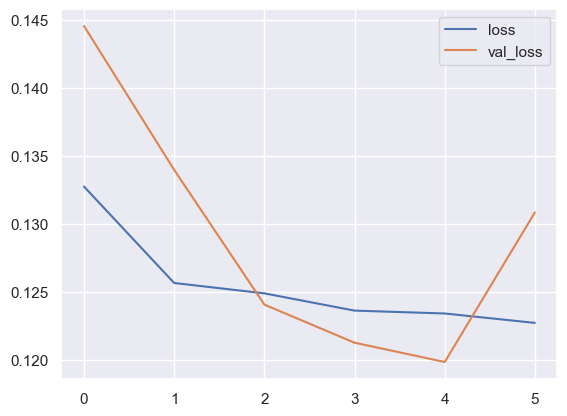

In [153]:
losses = pd.DataFrame(model.history.history)
losses.plot()

In [154]:
first_eval_batch = scaled_train[-length:]

In [155]:
first_eval_batch

array([[0.8738865 , 0.35382099, 0.58095769, 0.88888889, 1.        ,
        1.        , 0.57977836, 0.        , 0.        , 0.67967696],
       [0.99839856, 0.74409909, 0.49366117, 0.        , 0.        ,
        1.        , 0.04683223, 0.        , 1.        , 0.46562759],
       [0.74747273, 0.2108303 , 0.01256958, 0.11111111, 1.        ,
        0.        , 0.7639028 , 0.        , 0.        , 0.50063129],
       [0.42127915, 0.5139385 , 0.40749151, 0.11111111, 0.        ,
        0.        , 0.29174177, 0.        , 1.        , 0.23472942],
       [0.29156241, 0.50191967, 0.7707323 , 0.44444444, 1.        ,
        1.        , 0.64910875, 0.        , 1.        , 0.52346641],
       [0.13452107, 0.60441358, 0.13439441, 0.66666667, 0.        ,
        1.        , 0.81941385, 0.        , 0.        , 0.47207105],
       [0.43429086, 0.42713585, 0.36127129, 0.        , 1.        ,
        1.        , 0.81567528, 0.        , 1.        , 0.55374635],
       [0.99679712, 0.35963009, 0.7707933

In [156]:
first_eval_batch = first_eval_batch.reshape((1, length, scaled_train.shape[1]))

In [157]:
model.predict(first_eval_batch)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


array([[0.5331944 , 0.51175916, 0.56464136, 0.4899887 , 0.48709565,
        0.44340527, 0.5278222 , 0.40168783, 0.35915595, 0.5647203 ]],
      dtype=float32)

In [158]:
scaled_test[0]

array([0.70013012, 0.41615197, 0.66226264, 1.        , 0.        ,
       0.        , 0.52062888, 0.33333333, 0.        , 0.50269929])

In [159]:
n_features = scaled_train.shape[1]
test_preds = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_preds.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━

In [160]:
test_preds

[array([0.5331944 , 0.51175916, 0.56464136, 0.4899887 , 0.48709565,
        0.44340527, 0.5278222 , 0.40168783, 0.35915595, 0.5647203 ],
       dtype=float32),
 array([0.53104293, 0.52955705, 0.55243194, 0.49337876, 0.49809435,
        0.44784504, 0.54434395, 0.41283765, 0.38830954, 0.5676043 ],
       dtype=float32),
 array([0.5274827 , 0.5247846 , 0.53993857, 0.48675042, 0.49865875,
        0.43740106, 0.5359442 , 0.4324833 , 0.38370472, 0.560967  ],
       dtype=float32),
 array([0.5285349 , 0.52309895, 0.53478193, 0.48313007, 0.5031091 ,
        0.43217498, 0.53398085, 0.4592205 , 0.38431346, 0.559671  ],
       dtype=float32),
 array([0.52952355, 0.52053714, 0.530924  , 0.4795383 , 0.5064822 ,
        0.4297201 , 0.5331695 , 0.48858094, 0.38471115, 0.5589409 ],
       dtype=float32),
 array([0.5311239 , 0.5183948 , 0.52843684, 0.47666025, 0.5097685 ,
        0.4300562 , 0.5338379 , 0.51998067, 0.38520348, 0.5591358 ],
       dtype=float32),
 array([0.532909  , 0.5164388 , 0.526601

In [161]:
scaled_test

array([[0.70013012, 0.41615197, 0.66226264, 1.        , 0.        ,
        0.        , 0.52062888, 0.33333333, 0.        , 0.50269929],
       [0.50765689, 0.1724702 , 0.3282201 , 0.11111111, 1.        ,
        1.        , 0.94408839, 0.33333333, 1.        , 0.57425225],
       [0.69712741, 0.12175742, 0.46998012, 1.        , 0.        ,
        0.        , 0.58688831, 0.33333333, 0.        , 0.38604206],
       [0.16695026, 0.64988482, 0.02040355, 0.11111111, 1.        ,
        1.        , 0.93607717, 0.33333333, 1.        , 0.627868  ],
       [0.76528876, 0.37255033, 0.85022087, 1.        , 1.        ,
        0.        , 0.96438347, 0.33333333, 0.        , 0.76204885],
       [0.3824442 , 0.1415551 , 0.30320504, 0.88888889, 1.        ,
        1.        , 0.70074771, 0.33333333, 1.        , 0.65971527],
       [0.99049144, 0.41658598, 0.67791757, 0.55555556, 0.        ,
        0.        , 0.49709593, 0.33333333, 0.        , 0.71999216],
       [0.87478731, 0.63005375, 1.0002311

## 

## 

In [162]:
## Inverse transforming the scaled predictions to their original values for comparison with the test set and evaluation

true_predictions = scaler.inverse_transform(test_preds)

In [163]:

true_predictions = pd.DataFrame(data=true_predictions,columns=test.columns)

In [164]:
true_predictions.head()

Temperature   Humidity  SquareFootage  Occupancy  HVACUsage  LightingUsage  \
0    25.335145  45.344722    1564.724100   4.409898   0.487096       0.443405   
1    25.313650  45.877822    1552.523988   4.440409   0.498094       0.447845   
2    25.278080  45.734874    1540.040136   4.380754   0.498659       0.437401   
3    25.288592  45.684383    1534.887429   4.348171   0.503109       0.432175   
4    25.298470  45.607649    1531.032458   4.315845   0.506482       0.429720   

   RenewableEnergy  DayOfWeek   Holiday  EnergyConsumption  
0        15.819497   2.410127  0.359156          79.205120  
1        16.314456   2.477026  0.388310          79.337606  
2        16.062817   2.594900  0.383705          79.032703  
3        16.003998   2.755323  0.384313          78.973166  
4        15.979692   2.931486  0.384711          78.939626

## 

In [165]:
y_pred = true_predictions['EnergyConsumption']

In [166]:
y_test = test['EnergyConsumption']

# Evaluating the LSTM model

In [167]:
mean_absolute_error(y_test, y_pred)

6.882488800140717

In [168]:
mean_squared_error(y_test,y_pred)

65.19197384585289

In [169]:
np.sqrt(mean_squared_error(y_test,y_pred))

8.074154683052145

In [170]:
n_features = scaled_train.shape[1]
future_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(96):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    future_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━

In [171]:
future_predictions

[array([0.5331944 , 0.51175916, 0.56464136, 0.4899887 , 0.48709565,
        0.44340527, 0.5278222 , 0.40168783, 0.35915595, 0.5647203 ],
       dtype=float32),
 array([0.53104293, 0.52955705, 0.55243194, 0.49337876, 0.49809435,
        0.44784504, 0.54434395, 0.41283765, 0.38830954, 0.5676043 ],
       dtype=float32),
 array([0.5274827 , 0.5247846 , 0.53993857, 0.48675042, 0.49865875,
        0.43740106, 0.5359442 , 0.4324833 , 0.38370472, 0.560967  ],
       dtype=float32),
 array([0.5285349 , 0.52309895, 0.53478193, 0.48313007, 0.5031091 ,
        0.43217498, 0.53398085, 0.4592205 , 0.38431346, 0.559671  ],
       dtype=float32),
 array([0.52952355, 0.52053714, 0.530924  , 0.4795383 , 0.5064822 ,
        0.4297201 , 0.5331695 , 0.48858094, 0.38471115, 0.5589409 ],
       dtype=float32),
 array([0.5311239 , 0.5183948 , 0.52843684, 0.47666025, 0.5097685 ,
        0.4300562 , 0.5338379 , 0.51998067, 0.38520348, 0.5591358 ],
       dtype=float32),
 array([0.532909  , 0.5164388 , 0.526601

####  please note, to get the actual values, you need to also inverse transform  the scaled future prediction

# Summary Performance of both statistical and machine learning model

In [172]:
Performance_metrics = {
    'Holt-Winters (ExponentialSmoothing)': {
        'MAE': mean_absolute_error(test_data, test_predictions),
        'MSE': mean_squared_error(test_data, test_predictions),
        'RMSE': np.sqrt(mean_squared_error(test_data, test_predictions))
    },
    'AR (AutoRegressive)': {
        'MAE': mean_absolute_error(test_data, AR_test_predictions),
        'MSE': mean_squared_error(test_data, AR_test_predictions),
        'RMSE': np.sqrt(mean_squared_error(test_data, AR_test_predictions))
    },
    'ARIMA': {
        'MAE': mean_absolute_error(test_data, predictions),
        'MSE': mean_squared_error(test_data, predictions),
        'RMSE': np.sqrt(mean_squared_error(test_data, predictions))
    },
    'SARIMAX': {
        'MAE': mean_absolute_error(test_dataa['EnergyConsumption'],Sarimax_prediction),
        'MSE': mean_squared_error(test_dataa['EnergyConsumption'],Sarimax_prediction),
        'RMSE': np.sqrt(mean_squared_error(test_dataa['EnergyConsumption'],Sarimax_prediction))
    },
   'LSTM': {
        'MAE': mean_absolute_error(y_test, y_pred),
        'MSE': mean_squared_error(y_test, y_pred),
       'RMSE': np.sqrt(mean_squared_error(y_test, y_pred))
    }   
    
}

In [173]:
performance_df = pd.DataFrame(Performance_metrics).T

In [174]:
performance_df

MAE        MSE      RMSE
Holt-Winters (ExponentialSmoothing)  6.289712  55.410698  7.443836
AR (AutoRegressive)                  6.299767  56.688635  7.529186
ARIMA                                6.300802  56.640888  7.526014
SARIMAX                              5.200716  44.379048  6.661760
LSTM                                 6.882489  65.191974  8.074155

#  Model Performance Insights
Based on the evaluation of five forecasting models using Mean Absolute Error (MAE), Mean Squared Error (MSE), and Root Mean Squared Error (RMSE), we can derive the following insights:

#  Best Overall Model: SARIMAX

SARIMAX outperforms all other models across all three metrics, indicating better overall accuracy and lower error in both absolute and squared terms. It effectively captures both seasonality and exogenous influences, making it the most reliable choice for this dataset.

#  Traditional Statistical Models (Holt-Winters, AR, ARIMA)
These models perform moderately well, with Holt-Winters slightly better than AR and ARIMA in terms of MAE and MSE.

However, their errors are still significantly higher than SARIMAX, especially in MSE and RMSE, suggesting less effective handling of complexity in the data.

# Saving and Loading my best overall model 


In [176]:
import joblib 

In [177]:
joblib.dump(Sarimax_result, "Sarimax_model.pkl")

['Sarimax_model.pkl']

## Load and test saved model

In [178]:
loaded_model = joblib.load("Sarimax_model.pkl")

In [179]:
loaded_model

In [182]:
df2

Temperature  Occupancy  EnergyConsumption
Timestamp                                                     
2022-01-01 00:00:00    25.139433          5          75.364373
2022-01-01 01:00:00    27.731651          1          83.401855
2022-01-01 02:00:00    28.704277          2          78.270888
2022-01-01 03:00:00    20.080469          1          56.519850
2022-01-01 04:00:00    23.097359          9          70.811732
...                          ...        ...                ...
2022-02-11 11:00:00    28.619382          5          82.306692
2022-02-11 12:00:00    23.836647          4          66.577320
2022-02-11 13:00:00    23.005340          6          72.753471
2022-02-11 14:00:00    25.138365          3          76.950389
2022-02-11 15:00:00    23.051165          6          71.545311

[1000 rows x 3 columns]

In [183]:
# Using the first 20 data points of data to test saved model.

df2_subset = df2.iloc[:20]

In [191]:
df2_subset.head()

Temperature  Occupancy  EnergyConsumption  \
Timestamp                                                        
2022-01-01 00:00:00    25.139433          5          75.364373   
2022-01-01 01:00:00    27.731651          1          83.401855   
2022-01-01 02:00:00    28.704277          2          78.270888   
2022-01-01 03:00:00    20.080469          1          56.519850   
2022-01-01 04:00:00    23.097359          9          70.811732   

                     loaded_Sarimax_prediction  
Timestamp                                       
2022-01-01 00:00:00                  77.511129  
2022-01-01 01:00:00                  82.177105  
2022-01-01 02:00:00                  85.770117  
2022-01-01 03:00:00                  59.707634  
2022-01-01 04:00:00                  74.460776

In [197]:
loaded_Sarimax_prediction = loaded_model.predict(start =0,end=0+19,exog=df2_subset[['Temperature', 'Occupancy']])

In [198]:
loaded_Sarimax_prediction

Timestamp
2022-01-01 00:00:00    77.511129
2022-01-01 01:00:00    82.177105
2022-01-01 02:00:00    85.770117
2022-01-01 03:00:00    59.707634
2022-01-01 04:00:00    74.460776
2022-01-01 05:00:00    91.276916
2022-01-01 06:00:00    78.223521
2022-01-01 07:00:00    73.975155
2022-01-01 08:00:00    78.989516
2022-01-01 09:00:00    65.968982
2022-01-01 10:00:00    83.892184
2022-01-01 11:00:00    73.205759
2022-01-01 12:00:00    75.297040
2022-01-01 13:00:00    60.380482
2022-01-01 14:00:00    82.923344
2022-01-01 15:00:00    70.795843
2022-01-01 16:00:00    86.121370
2022-01-01 17:00:00    70.461883
2022-01-01 18:00:00    87.461191
2022-01-01 19:00:00    84.092671
Freq: h, Name: predicted_mean, dtype: float64

In [199]:
df2_subset['loaded_Sarimax_prediction']= loaded_Sarimax_prediction

In [201]:
df2_subset

Temperature  Occupancy  EnergyConsumption  \
Timestamp                                                        
2022-01-01 00:00:00    25.139433          5          75.364373   
2022-01-01 01:00:00    27.731651          1          83.401855   
2022-01-01 02:00:00    28.704277          2          78.270888   
2022-01-01 03:00:00    20.080469          1          56.519850   
2022-01-01 04:00:00    23.097359          9          70.811732   
2022-01-01 05:00:00    29.576037          6          84.321885   
2022-01-01 06:00:00    25.131167          6          76.165791   
2022-01-01 07:00:00    23.182844          8          74.131906   
2022-01-01 08:00:00    25.391999          6          78.206236   
2022-01-01 09:00:00    22.212549          1          77.992214   
2022-01-01 10:00:00    28.064814          2          82.274434   
2022-01-01 11:00:00    23.422546          6          73.278670   
2022-01-01 12:00:00    25.388888          1          84.144776   
2022-01-01 13:00:00    20.058738          2          60.022519   
2022-01-01 14:00:00    26.731525          6          81.183188   
2022-01-01 15:00:00    22.100243          8          74.081256   
2022-01-01 16:00:00    29.325576          0          89.498208   
2022-01-01 17:00:00    23.742447          1          72.872443   
2022-01-01 18:00:00    27.524189          9          83.899897   
2022-01-01 19:00:00    27.631390          4          82.077579   

                     loaded_Sarimax_prediction  
Timestamp                                       
2022-01-01 00:00:00                  77.511129  
2022-01-01 01:00:00                  82.177105  
2022-01-01 02:00:00                  85.770117  
2022-01-01 03:00:00                  59.707634  
2022-01-01 04:00:00                  74.460776  
2022-01-01 05:00:00                  91.276916  
2022-01-01 06:00:00                  78.223521  
2022-01-01 07:00:00                  73.975155  
2022-01-01 08:00:00                  78.989516  
2022-01-01 09:00:00                  65.968982  
2022-01-01 10:00:00                  83.892184  
2022-01-01 11:00:00                  73.205759  
2022-01-01 12:00:00                  75.297040  
2022-01-01 13:00:00                  60.380482  
2022-01-01 14:00:00                  82.923344  
2022-01-01 15:00:00                  70.795843  
2022-01-01 16:00:00                  86.121370  
2022-01-01 17:00:00                  70.461883  
2022-01-01 18:00:00                  87.461191  
2022-01-01 19:00:00                  84.092671

	
## ✅ The saved model is performing well, and I'm now ready to move forward with deploying it into production using Streamlit.

# MY Portfolio: https://www.datascienceportfol.io/Patrick090

# Linkedlin: https://www.linkedin.com/in/patrickedosoma/